In [33]:
from scipy.interpolate import interp1d
from mpmath import besselk, rgamma, mp
import numpy as np
import time
from scipy.integrate import simps
import Decomposition as DC
import Cosmology as Csm
from matplotlib import pyplot as plt

defcos = Csm.MyCosmology()

#########################################################
#Precalculating all the cosmology terms
sampling_cosmo = Csm.Sampling() #Here we can vary the cosmological parameters
khmin = 1e-8
khmax = 52.0
Nmax = 200
c_n_array = sampling_cosmo.CoeffTransfer(sampling_cosmo.default_cosmo.Plin, 0, 0, Nmax, khmin, khmax)[:, 0]
nu_n_array = sampling_cosmo.CoeffTransfer(sampling_cosmo.default_cosmo.Plin, 0, 0, Nmax, khmin, khmax)[:, 1]
#We test non-zero bias term
b_test = -0.1
c_n_array_b = sampling_cosmo.CoeffTransfer(sampling_cosmo.default_cosmo.Plin, b_test , 0, Nmax, khmin, khmax)[:, 0]
nu_n_array_b = sampling_cosmo.CoeffTransfer(sampling_cosmo.default_cosmo.Plin, b_test , 0, Nmax, khmin, khmax)[:, 1]
print('Linear Power Spectrum at z=0 expanded. The number of expansion terms is: %d'%len(c_n_array))

mp.dps=25
mp.pretty=True
Nmax = 200
#nu_n_array = np.load('./nu_n_array.npy')
print('The complex frequency array is read. The corresponding length is:', len(nu_n_array))

np_rgamma = np.vectorize(rgamma)
np_besselk = np.vectorize(besselk)

def M1i_lensing(x_i, nu_i_l):
    '''
    This function calculates the single term when evaluating expanding FT of power spectrum
    According to the note in mpmath, z=0 is a pole for Gamma(z) function, but 1/Gamma should be 0,
    therefore we adapted the alternative rgamma(z) for 1/Gamma in the mpmath package,
    which deals with this pole.

    Params:
    x_i: is the redefined parameter, the same as delta_chi*l_tilde
    nu_i_l: is the ith complex order from power expansion of matter power spectrum, 
            when we try to calculate lensing, we need to modify it by minus 4.
    c_i: is the ith coeffecient

    Return:
    A complex number
    '''
    nu_i = nu_i_l - 4
    #nu_i = nu_i_l
    number = (2 / x_i)**(0.5*nu_i+0.5)*np_besselk(-0.5-0.5*nu_i, x_i)*np_rgamma(-0.5*nu_i)/np.sqrt(np.pi)
    return np.array([num.real for num in number]), np.array([num.imag for num in number])

def special_func_lensing_interp(nu_n_array, x_array, Nmax):
    '''
    Contains of a list of interpolated real functions, corresponding to the real part and imaginary part of the modifed function
    '''
    func_real_list = []
    func_imag_list = []
    #for i in range(1, int(Nmax/2)+1):  #Here we only take half of the coeffecient array, since it is symmetric
    
    for i in range(int(Nmax)+1):
        #nu_i = nu_n_array[i+int(Nmax/2)]
        nu_i = nu_n_array[i]
        y_real_array, y_imag_array = M1i_lensing(x_array, nu_i)
        func_real_list.append(interp1d(x_array, y_real_array))
        func_imag_list.append(interp1d(x_array, y_imag_array))
    '''
    for i in range(1, int(Nmax/2)+1):  #Here we only take half of the coeffecient array, since it is symmetric
        nu_i = nu_n_array[i+int(Nmax/2)]
        y_real_array, y_imag_array = M1i_lensing(x_array, nu_i)
        func_real_list.append(interp1d(x_array, y_real_array))
        func_imag_list.append(interp1d(x_array, y_imag_array))
    '''
    return func_real_list, func_imag_list

def M1i(x_i, nu_i):
    '''
    This function calculates the single term when evaluating expanding FT of power spectrum
    According to the note in mpmath, z=0 is a pole for Gamma(z) function, but 1/Gamma should be 0,
    therefore we adapted the alternative rgamma(z) for 1/Gamma in the mpmath package,
    which deals with this pole.

    Params:
    x_i: is the redefined parameter, the same as delta_chi*l_tilde
    nu_i: is the ith complex order from power expansion
    c_i: is the ith coeffecient

    Return:
    A complex number
    '''
    
    number = (2 * x_i)**(0.5*nu_i+0.5)*np_besselk(-0.5-0.5*nu_i, x_i)*np_rgamma(-0.5*nu_i)/np.sqrt(np.pi)
    return np.array([num.real for num in number]), np.array([num.imag for num in number])

def M2i(x_i, nu_i):
    '''
    For x_i not equal to zero.
    In order to avoid the dchi=0 pole in the following calculation
    '''
    number = (2/x_i)**(0.5*nu_i+0.5)*np_besselk(-0.5-0.5*nu_i, x_i)*np_rgamma(-0.5*nu_i)/np.sqrt(np.pi)
    return [num.real for num in number], [num.imag for num in number]

def special_func1_interp(nu_n_array, x_array, Nmax):
    '''
    Contains of a list of interpolated real functions, corresponding to the real part and imaginary part of the modifed function
    '''
    func_real_list = []
    func_imag_list = []
    '''
    for i in range(1, int(Nmax/2)+1):  #Here we only take half of the coeffecient array, since it is symmetric
        nu_i = nu_n_array[i+int(Nmax/2)]
        y_real_array, y_imag_array = M1i(x_array, nu_i)
        func_real_list.append(interp1d(x_array, y_real_array))
        func_imag_list.append(interp1d(x_array, y_imag_array))
    '''
    for i in range(int(Nmax)+1):  #Here we only take half of the coeffecient array, since it is symmetric
        nu_i = nu_n_array[i]
        y_real_array, y_imag_array = M1i(x_array, nu_i)
        func_real_list.append(interp1d(x_array, y_real_array))
        func_imag_list.append(interp1d(x_array, y_imag_array))
        
    return func_real_list, func_imag_list
def special_func2_interp(nu_n_array, x_array, Nmax):
    '''
    Contains of a list of interpolated real functions, corresponding to the real part and imaginary part of the modifed function
    Note that x_array is always non-negative because of the certain symmetry. And x_array[0] must be 0
    ToDo:
    Add a term that could enable the calculation for x=0
    '''
    func_real_list = []
    func_imag_list = []
    '''
    for i in range(1, int(Nmax/2)+1):  #Here we only take half of the coeffecient array, since it is symmetric
        nu_i = nu_n_array[i+int(Nmax/2)]
        y_real_array, y_imag_array = M2i(x_array, nu_i)
        func_real_list.append(interp1d(x_array, np.array(y_real_array)))
        func_imag_list.append(interp1d(x_array, np.array(y_imag_array)))
    '''
    for i in range(int(Nmax)+1):  #Here we only take half of the coeffecient array, since it is symmetric
        nu_i = nu_n_array[i]+b_test
        y_real_array, y_imag_array = M2i(x_array, nu_i)
        #y_real_0, y_imag_0 = M2i(np.array([1e-6]), nu_i) #This should be improved to actual 0 in the short future
        func_real_list.append(interp1d(x_array, y_real_array))
        func_imag_list.append(interp1d(x_array, y_imag_array))
    
    return func_real_list, func_imag_list

def curl_Cl_special1(l, chi, dchi_array, func_real_list, func_imag_list):
    '''
    This function is used to calculate the curly Cl using special function approach
    '''
    xx = dchi_array*l/(chi+0.5*dchi_array)
    Cl_array_array = np.array([ (c_n_array[i]*(func_real_list[i](np.abs(xx))+1j*func_imag_list[i](np.abs(xx))))*\
        np.abs(dchi_array)**(-nu_n_array[i]-1) for i in range(int(Nmax)+1)])
    Cl_array = np.sum(Cl_array_array, axis=0)
    return Cl_array

def curl_Cl_special_lensing(l, chi, dchi_array, func_real_list, func_imag_list):
    '''
    This function is used to calculate the curly Cl using special function approach
    '''
    xx = dchi_array*l/(chi+0.5*dchi_array)
    l_tilde = l/(chi+0.5*dchi_array)
    #Cl_array_array = np.array([ (c_n_array[i]*(func_real_list[i](np.abs(xx))+1j*func_imag_list[i](np.abs(xx))))*\
        #np.abs(dchi_array)**(-nu_n_array[i]-1+4) for i in range(int(Nmax)+1)])
    Cl_array_array = np.array([ (c_n_array[i]*(func_real_list[i](np.abs(xx))+1j*func_imag_list[i](np.abs(xx))))*\
        np.abs(l_tilde)**(nu_n_array[i]+1-4) for i in range(int(Nmax)+1)])
    Cl_array = np.sum(Cl_array_array, axis=0)*(1-dchi_array/2/chi)**2/(1+dchi_array/2/chi)**2
    return Cl_array

def curl_Cl_special2(l, chi, dchi_array, func_real_list, func_imag_list):
    '''
    This function is used to calculate the curly Cl using special function approach
    '''
    xx = dchi_array*l/(chi+0.5*dchi_array)
    l_tilde = l/(chi+0.5*dchi_array)
    Cl_array_array = np.array([ (c_n_array[i]*(func_real_list[i](np.abs(xx))+1j*func_imag_list[i](np.abs(xx))))*\
        np.abs(l_tilde)**(nu_n_array[i]+1) for i in range(int(Nmax)+1)])
    Cl_array = np.sum(Cl_array_array, axis=0)

    return Cl_array

def curl_Cl_special2_mod(l, chi, dchi_array, func_real_list, func_imag_list):
    '''
    This function is used to calculate the curly Cl using special function approach
    '''
    xx = dchi_array*np.sqrt(l*(l+1))/(chi+0.5*dchi_array)/(1-(dchi_array/2/chi))
    l_tilde = np.sqrt(l*(l+1))/(chi+0.5*dchi_array)/(1-(dchi_array/2/chi))
    Cl_array_array = np.array([ (c_n_array[i]*(func_real_list[i](np.abs(xx))+1j*func_imag_list[i](np.abs(xx))))*\
        np.abs(l_tilde)**(nu_n_array[i]+1) for i in range(int(Nmax)+1)])
    Cl_array = np.sum(Cl_array_array, axis=0)

    return Cl_array

def power_calc_sampling1(l, n, chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, c_n_array, func_real_list, func_imag_list):
    '''
    Params:
    l: The multiple
    n: The order of our approximation, usually order 0 will be good enough
    chi_chi, dchi_dchi: The 2D mesh-grid of the chi (dchi) parameter. 
                        The n_row is the same as length of dchi array, 
                        while the n_columns is the same as length of chi array.
    D1_D1, D2_D2: The mesh-grid of growth factor. The same shape as chi_chi.
    Wg1_Wg1, Wg2_Wg2: The mesh-grid of several window functions.

    Return:
    The angular power spetrum at mutiple l.
    '''
    xx = dchi_dchi*l/(chi_chi+0.5*dchi_dchi)
    l_tilde = l/(chi_chi+0.5*dchi_dchi)
    Cl_array_array = np.array([ (c_n_array[i]*(func_real_list[i](np.abs(xx))+1j*func_imag_list[i](np.abs(xx))))*\
        np.abs(l_tilde)**(nu_n_array[i]+1) for i in range(int(Nmax)+1)])
    '''
    Cl_array_array = np.array([ (c_n_array[i]*(func_real_list[i](np.abs(xx))+1j*func_imag_list[i](np.abs(xx))))*\
        np.abs(dchi_dchi)**(-nu_n_array[i]-1) for i in range(int(Nmax)+1)])
    '''
    Cl_array = np.sum(Cl_array_array, axis=0)

    Simp_array = D1_D1*D2_D2*Cl_array*Wg1_Wg1*Wg2_Wg2*(dchi_dchi/chi_chi)**n/chi_chi**2
    #Simp_array = D1_D1*D2_D2*Cl_array*Wg1_Wg1*Wg2_Wg2*(dchi_dchi/chi_chi)**n/chi_chi**2
    results = simps(simps(Simp_array, chi_chi[0, :]), dchi_dchi[:, 0])
    return results

def full_calc_sampling1(l_array, n, z1, z2, sigma1, sigma2, Nchi, Ndchi, func_real_list, func_imag_list, c_n_array = c_n_array):
    '''
    Params:
    l_array: The array of multiples we have chosen to consider
    The meaning of rest parameters could be found above
    c_n_array: the decomposed coefficients array

    Return:
    An list of angular power spectrum given l_array
    '''
    start1 = time.time()
    chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2 = sampling_cosmo.mesh_grid_generator(z1, z2, sigma1, sigma2, Nchi, Ndchi)
    end1 = time.time()-start1
    print('Time for preparing mesh-grids is:', end1, 's')
    start2 = time.time()
    power_array = [power_calc_sampling1(li, n, chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, c_n_array, func_real_list, func_imag_list).real for li in l_array]
    end2 = (time.time()-start2)/len(l_array)
    print('Time for calculating each l is:', end2, 's')

    return np.array(power_array)


Linear Power Spectrum at z=0 expanded. The number of expansion terms is: 201
The complex frequency array is read. The corresponding length is: 201


In [2]:
x_min = 1e-7
x_max = 1e7
N_sample = 2000
x_test = np.array(list(10**np.array([np.log10(x_min) + np.log10(x_max/x_min)/N_sample*i for i in range(N_sample+1)])))
#x_list = 10**np.array([np.log10(x_min) + np.log10(x_max/x_min)/N_sample*i for i in range(N_sample)])
#x_test = np.array(list(-x_list[::-1])+list(x_list))
 #Sampling in log scale, changing the sampling points will significantly change the time of evaluation

print('Number of interpolation sampling points are:', N_sample)
print('Modified arguments are in the interval of', '[', x_min, ',', x_max, ']')
print('Creating the modified functions...')

start = time.time()
#func_real_list1, func_imag_list1 = special_func1_interp(nu_n_array, x_test, Nmax = Nmax)
func_real_list2, func_imag_list2 = special_func2_interp(nu_n_array, x_test, Nmax = Nmax)
end = (time.time()-start)/60
print('Function tools activated.')
print('Time consumed:', end, 'min')
print('Linear Power Spectrum at z=0 expanded. The number of expansion terms is: %d'%len(c_n_array))

Number of interpolation sampling points are: 2000
Modified arguments are in the interval of [ 1e-07 , 10000000.0 ]
Creating the modified functions...
Function tools activated.
Time consumed: 4.89995254278183 min
Linear Power Spectrum at z=0 expanded. The number of expansion terms is: 201


In [344]:
x_min = 1e-6
x_max = 1e5
N_sample = 2000
x_test = np.array(list(10**np.array([np.log10(x_min) + np.log10(x_max/x_min)/N_sample*i for i in range(N_sample+1)])))
#x_list = 10**np.array([np.log10(x_min) + np.log10(x_max/x_min)/N_sample*i for i in range(N_sample)])
#x_test = np.array(list(-x_list[::-1])+list(x_list))
 #Sampling in log scale, changing the sampling points will significantly change the time of evaluation

print('Number of interpolation sampling points are:', N_sample)
print('Modified arguments are in the interval of', '[', x_min, ',', x_max, ']')
print('Creating the modified functions...')

start = time.time()
func_real_list1, func_imag_list1 = special_func_lensing_interp(nu_n_array, x_test, Nmax = Nmax)
#func_real_list2, func_imag_list2 = special_func2_interp(nu_n_array, x_test, Nmax = Nmax)
end = (time.time()-start)/60
print('Function tools activated.')
print('Time consumed:', end, 'min')
print('Linear Power Spectrum at z=0 expanded. The number of expansion terms is: %d'%len(c_n_array))

Number of interpolation sampling points are: 2000
Modified arguments are in the interval of [ 1e-06 , 100000.0 ]
Creating the modified functions...
Function tools activated.
Time consumed: 4.984691882133484 min
Linear Power Spectrum at z=0 expanded. The number of expansion terms is: 201


In [210]:
x_test.max()

1000000.0

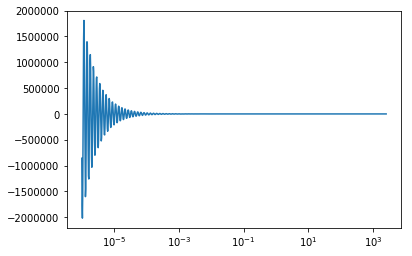

In [165]:
for i in range(1):
    plt.semilogx(x_test[1:],func_real_list2[i](x_test[1:]))

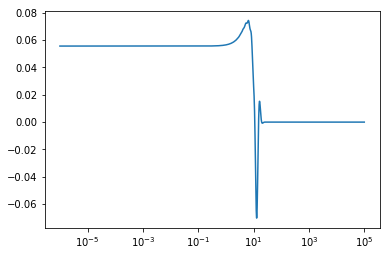

In [425]:
for i in range(1):
    plt.semilogx(x_test,func_real_list1[i](x_test))

In [155]:
print(M2i(np.array([1e-8]),nu_n_array[0]))
print(func_real_list2[0](1e-8))
print(func_real_list2[0](1e-6))

([107358618.6924168443766397], [-181520010.1771722551507372])
-857909.7889588416
-857909.7889588416


Text(0, 0.5, '$P_{\\Psi}(k=0.1)$')

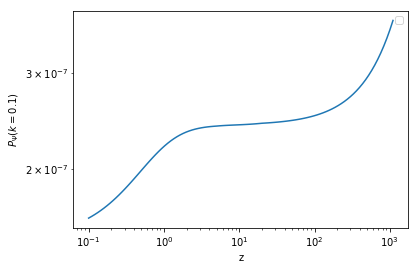

In [875]:
#Test basic cosmology parameters
defcos = Csm.MyCosmology()

def lensing_potential_3D(z1, z2, kh_array):

    chi1 = defcos.chi(z1)
    chi2 = defcos.chi(z2)
    Psi1 = defcos.Psi_normalizer(chi1)*defcos.Dg_norm(chi1)
    Psi2 = defcos.Psi_normalizer(chi2)*defcos.Dg_norm(chi2)

    return Psi1*Psi2*defcos.Plin(kh_array)/kh_array**4

z_list = 10**np.array([-1 + np.log10(1100/0.1)/100*i for i in range(101)])
kh_array = 10**np.array([-4 + i*5/100 for i in range(101)])
p_psi = np.array([lensing_potential_3D(zz, zz, 0.1) for zz in z_list])

plt.loglog(z_list, p_psi)
plt.legend()
plt.xlabel(r'z')
plt.ylabel(r'$P_{\Psi}(k=0.1)$')



In [109]:
chi1_array = defcos.chi(z_array)
chi2_array = defcos.chi(z_array)

chi1_chi1, chi2_chi2 = np.meshgrid(chi1_array, chi2_array)
print(np.shape(chi1_chi1))
print(np.shape(chi2_chi2))

chi_chi = (chi1_chi1+chi2_chi2)/2
dchi_dchi = (chi2_chi2-chi1_chi1)

(1001, 1001)
(1001, 1001)


In [125]:
import scipy.fft
import cmath
from scipy.interpolate import interp1d

def Pk_potent(kh):

    return sampling_cosmo.default_cosmo.Plin(kh)/kh**4
    
def Power_spectrum(kh_par, l, chi, dchi):

    #chi = (chi1+chi2)/2
    #delta_chi = chi2-chi1
    #chi = chi1
    #delta_chi = chi2
    kh = np.sqrt(kh_par**2 + (l/(chi+0.5*dchi))**2)

    return Pk_potent(kh)

def C_fft(l, chi, dchi):
    '''
    Here we use the FFT algorithm to calculate the Equation(34), which formally a 1D Fourier transformation
    N here is the number of discrete points that we need.
    '''
    #Creat power spectrum array in respect of k_par
    kh_par_min, kh_par_max = 0,10 #kh_par_min_max(l, chi)
    '''
    if delta_chi>=40:
        dkh_crit = 2*np.pi/delta_chi/10
        N_crit = int(kh_par_max/dkh_crit)
        if N_crit>10000:
            dkh = 2*np.pi/delta_chi/2.5
            N = int(kh_par_max/dkh)
        else:
            dkh = dkh_crit
            N = N_crit
    else:
        dkh = kh_par_max/5000
        N = 5000
    '''
    dkh = kh_par_max/700000
    N = 700000
    #print('Number of Samples:', N)
    #N = int((k_par_max-k_par_min)/dk)
    #k_par_array =np.array(list(-10**np.array([np.log10(k_par_min+1e-8) + (np.log10(k_par_max/1e-8)*2/N)*i for i in range(int(N/2))]))[::-1]+\
                #list(10**np.array([np.log10(k_par_min+1e-8) + (np.log10(k_par_max/1e-8)*2/N)*i for i in range(int(N/2))])))
    #k_par_array = np.array([-k_par_max + k_par_max*2/N*i for i in range(int(N/2))]+[k_par_min + k_par_max*2/N*i for i in range(int(N/2))])
    kh_par_array = [-dkh*N/2 + dkh*i for i in range(N)]
 
    kh_par = scipy.fft.fftshift(kh_par_array)
    power_array = Power_spectrum(kh_par, l, chi, dchi)
    C_array = scipy.fft.fftshift(scipy.fft.ifft(power_array))
    w_array = scipy.fft.fftshift(scipy.fft.fftfreq(len(power_array))*2*np.pi/dkh)
    C_array *= [N*dkh*cmath.exp(1j*w*kh_par_min).real/(2*np.pi) for w in w_array]

    C_fft_func = interp1d(w_array, np.real(C_array))
    return C_fft_func(dchi)
###########################################################################################################################################
#Test kappa field power spectrum
def Pk_potent_kappa(kh):

    return sampling_cosmo.default_cosmo.Plin(kh)
    
def Power_spectrum_kappa(kh_par, l, chi, dchi):

    #chi = (chi1+chi2)/2
    #delta_chi = chi2-chi1
    #chi = chi1
    #delta_chi = chi2
    kh = np.sqrt(kh_par**2 + (l/(chi+0.5*dchi))**2)

    return (1-kh_par**2/kh**2)**2*Pk_potent_kappa(kh)

def C_fft_kappa(l, chi, dchi):
    '''
    Here we use the FFT algorithm to calculate the Equation(34), which formally a 1D Fourier transformation
    N here is the number of discrete points that we need.
    '''
    #Creat power spectrum array in respect of k_par
    kh_par_min, kh_par_max = 0,10 #kh_par_min_max(l, chi)
    '''
    if delta_chi>=40:
        dkh_crit = 2*np.pi/delta_chi/10
        N_crit = int(kh_par_max/dkh_crit)
        if N_crit>10000:
            dkh = 2*np.pi/delta_chi/2.5
            N = int(kh_par_max/dkh)
        else:
            dkh = dkh_crit
            N = N_crit
    else:
        dkh = kh_par_max/5000
        N = 5000
    '''
    dkh = kh_par_max/70000
    N = 70000
    #print('Number of Samples:', N)
    #N = int((k_par_max-k_par_min)/dk)
    #k_par_array =np.array(list(-10**np.array([np.log10(k_par_min+1e-8) + (np.log10(k_par_max/1e-8)*2/N)*i for i in range(int(N/2))]))[::-1]+\
                #list(10**np.array([np.log10(k_par_min+1e-8) + (np.log10(k_par_max/1e-8)*2/N)*i for i in range(int(N/2))])))
    #k_par_array = np.array([-k_par_max + k_par_max*2/N*i for i in range(int(N/2))]+[k_par_min + k_par_max*2/N*i for i in range(int(N/2))])
    kh_par_array = [-dkh*N/2 + dkh*i for i in range(N)]
 
    kh_par = scipy.fft.fftshift(kh_par_array)
    power_array = Power_spectrum_kappa(kh_par, l, chi, dchi)
    C_array = scipy.fft.fftshift(scipy.fft.ifft(power_array))
    w_array = scipy.fft.fftshift(scipy.fft.fftfreq(len(power_array))*2*np.pi/dkh)
    C_array *= [N*dkh*cmath.exp(1j*w*kh_par_min).real/(2*np.pi) for w in w_array]

    C_fft_func = interp1d(w_array, np.real(C_array))
    return C_fft_func(dchi)


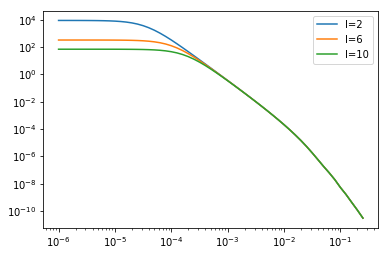

In [82]:
kh_par_array = 10**np.array([-6 + 0.1*i for i in range(55)])
plt.loglog(kh_par_array, Power_spectrum(kh_par_array, 2, defcos.chi(10), 1e5)/1e16,label=r'l=2')
plt.loglog(kh_par_array, Power_spectrum(kh_par_array, 6, defcos.chi(10), 1e5)/1e16,label=r'l=6')
plt.loglog(kh_par_array, Power_spectrum(kh_par_array, 10, defcos.chi(10), 1e5)/1e16,label=r'l=10')

plt.legend()

### Compare the $\mathcal{C_\ell}$ generated by FFT, M1i(x) and M2i(x):

In [132]:
C_fft(10, chi, -1000)

array(1.4727779e+11)

In [348]:
l = 100
chi = defcos.chi(10)
dchi_array = np.array(list(10**np.array([np.log10(0.1) + i*np.log10(400000)/100 for i in range(101)])))

In [95]:
C2_fft_array = np.array([C_fft(2, chi, dchi) for dchi in dchi_array])
C4_fft_array = np.array([C_fft(4, chi, dchi) for dchi in dchi_array])
C10_fft_array = np.array([C_fft(10, chi, dchi) for dchi in dchi_array])

In [127]:
C2_fft_kappa = np.array([C_fft_kappa(2, chi, dchi) for dchi in dchi_array])
C4_fft_kappa = np.array([C_fft_kappa(4, chi, dchi) for dchi in dchi_array])
C10_fft_kappa = np.array([C_fft_kappa(10, chi, dchi) for dchi in dchi_array])

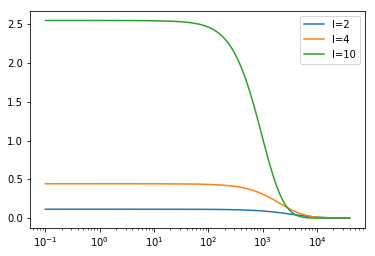

In [108]:
plt.semilogx(dchi_array, C2_fft_kappa,label='l=2')
plt.semilogx(dchi_array, C4_fft_kappa,label='l=4')
plt.semilogx(dchi_array, C10_fft_kappa,label='l=10')

plt.legend()

In [579]:
#C2_fft_array = np.array([C_fft(2, chi, dchi) for dchi in dchi_array])
C4_fft_array = np.array([C_fft(4, chi, dchi) for dchi in dchi_array])
#C10_fft_array = np.array([C_fft(10, chi, dchi) for dchi in dchi_array])
#C100_fft_array = np.array([C_fft(100, chi, dchi) for dchi in dchi_array])
#C500_fft_array = np.array([C_fft(500, chi, dchi) for dchi in dchi_array])

In [284]:
#C10_special1_array = curl_Cl_special1(l, chi, dchi_array, func_real_list1, func_imag_list1)
C2_special2_array = curl_Cl_special2(2, defcos.chi(2.0), dchi_array, func_real_list2, func_imag_list2)
C4_special2_array = curl_Cl_special2(4, defcos.chi(2.0), dchi_array, func_real_list2, func_imag_list2)
C6_special2_array = curl_Cl_special2(6, defcos.chi(2.0), dchi_array, func_real_list2, func_imag_list2)
C10_special2_array = curl_Cl_special2(10, defcos.chi(2.0), dchi_array, func_real_list2, func_imag_list2)
C100_special2_array = curl_Cl_special2(100, defcos.chi(2.0), dchi_array, func_real_list2, func_imag_list2)
C500_special2_array = curl_Cl_special2(500, defcos.chi(2.0), dchi_array, func_real_list2, func_imag_list2)
#C1000_special2_array = curl_Cl_special2(1000, defcos.chi(2.0), dchi_array, func_real_list2, func_imag_list2)

In [305]:
C2_special2_mod_array = curl_Cl_special2_mod(2, defcos.chi(2.0), dchi_array, func_real_list2, func_imag_list2)
C4_special2_mod_array = curl_Cl_special2_mod(4, defcos.chi(2.0), dchi_array, func_real_list2, func_imag_list2)
C6_special2_mod_array = curl_Cl_special2_mod(6, defcos.chi(2.0), dchi_array, func_real_list2, func_imag_list2)
C10_special2_mod_array = curl_Cl_special2_mod(10, defcos.chi(2.0), dchi_array, func_real_list2, func_imag_list2)
C100_special2_mod_array = curl_Cl_special2_mod(100, defcos.chi(2.0), dchi_array, func_real_list2, func_imag_list2)
C500_special2_mod_array = curl_Cl_special2_mod(500, defcos.chi(2.0), dchi_array, func_real_list2, func_imag_list2)

In [374]:
C2_lensing_array = curl_Cl_special_lensing(2, chi, dchi_array, func_real_list1, func_imag_list1)
C4_lensing_array = curl_Cl_special_lensing(4, chi, dchi_array, func_real_list1, func_imag_list1)
C6_lensing_array = curl_Cl_special_lensing(6, chi, dchi_array, func_real_list1, func_imag_list1)
C10_lensing_array = curl_Cl_special_lensing(10, chi, dchi_array, func_real_list1, func_imag_list1)
C100_lensing_array = curl_Cl_special_lensing(100, chi, dchi_array, func_real_list1, func_imag_list1)
C500_lensing_array = curl_Cl_special_lensing(500, chi, dchi_array, func_real_list1, func_imag_list1)

Text(0, 0.5, '$\\mathcal{C}_\\ell(\\delta\\chi)/\\mathcal{C}_\\ell(0)$')

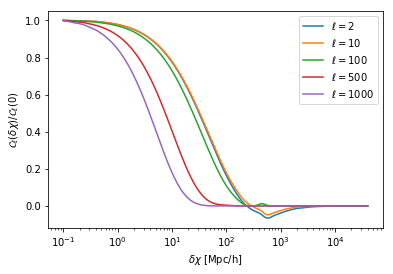

In [421]:
#plt.semilogx(dchi_array, C10_fft_array)
#plt.semilogx(dchi_array, C10_special1_array,'--')
plt.semilogx(dchi_array, C2_fft_array.real/C2_fft_array[0].real,label=r'$\ell=2$')
plt.semilogx(dchi_array, C10_fft_array.real/C10_fft_array[0].real,label=r'$\ell=10$')
plt.semilogx(dchi_array, C100_special2_array.real/C100_special2_array[0].real,label=r'$\ell=100$')
plt.semilogx(dchi_array, C500_special2_array.real/C500_special2_array[0].real,label=r'$\ell=500$')
plt.semilogx(dchi_array, C1000_special2_array.real/C1000_special2_array[0].real,label=r'$\ell=1000$')

plt.legend()
plt.xlabel(r'$\delta\chi\rm\ [Mpc/h]$')
plt.ylabel(r'$\mathcal{C}_\ell(\delta\chi)/\mathcal{C}_\ell(0)$')

Text(0, 0.5, '$\\mathcal{C}_\\ell(\\delta\\chi)/\\mathcal{C}_\\ell(0)$')

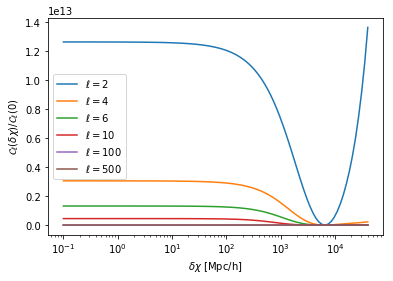

In [350]:
plt.semilogx(dchi_array, C2_lensing_array.real,label=r'$\ell=2$')
#plt.semilogx(dchi_array, C2_fft_array.real/C2_fft_array[0].real,'--',label=r'$\ell=2$')
plt.semilogx(dchi_array, C4_lensing_array.real,label=r'$\ell=4$')
plt.semilogx(dchi_array, C6_lensing_array.real,label=r'$\ell=6$')
plt.semilogx(dchi_array, C10_lensing_array.real,label=r'$\ell=10$')
plt.semilogx(dchi_array, C100_lensing_array.real,label=r'$\ell=100$')
plt.semilogx(dchi_array, C500_lensing_array.real,label=r'$\ell=500$')

plt.legend()
plt.xlabel(r'$\delta\chi\rm\ [Mpc/h]$')
plt.ylabel(r'$\mathcal{C}_\ell(\delta\chi)/\mathcal{C}_\ell(0)$')

### Here we calculate the $\mathcal{C}_\ell$ in full-sky regime, based on FFTLog expansion. 

With some calculation, we try to compare the following expression with our curly C_ell:

\begin{equation}
\mathcal{C}_\ell (\chi, \delta\chi) = \sum c_n (\chi+\frac{1}{2}\delta\chi)^{1-\nu_n}\times I_\ell(\nu_n,t),
\end{equation}

where $t = (1-0.5\delta)/(1+0.5\delta)$, and 

\begin{equation} 
I_\ell(\nu_n,t) = \frac{1}{4\pi} \frac{2^{\nu_n-2}\pi^2 \Gamma(\ell+\frac{\nu_n-1}{2})}{\Gamma(\frac{4-\nu_n}{2})\Gamma(\ell+\frac{3}{2})} t^\ell\  _{2}F_{1}(\frac{\nu_n-2}{2}, \ell+\frac{\nu_n-1}{2}, \ell+\frac{3}{2};t^2),\ t<1
\end{equation}

For $t>1$, we should use the property,
\begin{equation}
I_\ell(\nu, t) = t^{-\nu}I_\ell(\nu,\frac{1}{t})
\end{equation}

In [745]:
from mpmath import hyp2f1, gamma
np_hyp2f1 = np.vectorize(hyp2f1)

def I_l_cluster(l, nu, t):
    '''
    This is the special function derived from integral of spherical harmonics
    t<1
    '''
    term1 = 2**(nu+2)*gamma(l+0.5*(nu+3))*rgamma(0.5*(-nu))/gamma(l+1.5)
    term2 = hyp2f1(0.5*(nu+2), l+0.5*(nu+3), l+1.5, t**2)

    number = np.pi/4 * term1*term2 * t**l
    #return np.array([float(num.real) for num in number]), np.array([float(num.imag) for num in number])
    return float(number.real)+1j*float(number.imag)
def I_l_cluster_extra(l,nu,t):
    '''
    This is the analytical extrapolation of the above equation for t>1 case
    '''
    
    number = t**(-nu)*I_l_cluster(l,nu,1/t)
    return number.real

np_I_l_cluster = np.vectorize(I_l_cluster)
np_I_l_cluster_extra = np.vectorize(I_l_cluster_extra)

def I_l_mesh(l, nu, chi_chi, dchi_dchi):

    chi1 = chi_chi + 0.5*dchi_dchi
    chi2 = chi_chi - 0.5*dchi_dchi
    Ndchi = len(dchi_dchi[:,0])
    Nchi = len(chi_chi[0,:])

    tt1 = chi1[:int(Ndchi/2),:]/chi2[:int(Ndchi/2),:] #dchi negative part
    tt2 = chi2[int(Ndchi/2):,:]/chi1[int(Ndchi/2):,:] #dchi positive part

    mesh1 = chi2[:int(Ndchi/2),:]**(-3-nu)*np_I_l_cluster(l,nu,tt1)
    mesh2 = chi1[int(Ndchi/2):,:]**(-3-nu)*np_I_l_cluster(l,nu,tt2)

    return np.array(list(mesh1)+list(mesh2))

def curly_C_cluster(l, chi, dchi_array, c_n_array):
    '''
    Sum over all the complex frequencies to get the final curly C
    '''
    chi1 = chi + 0.5*dchi_array
    chi2 = chi - 0.5*dchi_array
    tt = chi2/chi1
    Cl_array_array = np.array([c_n_array[i]*chi1**(-3-nu_n_array[i])*np_I_l_cluster(l, nu_n_array[i], tt) for i in range(int(Nmax)+1)])
    Cl_array = np.sum(Cl_array_array, axis=0)

    return Cl_array.real

def curly_C_cluster_mesh(l, chi_chi, dchi_dchi, c_n_array):
    
    Cl_array_0 = I_l_mesh(l,nu_n_array[int(Nmax/2)],chi_chi, dchi_dchi)*c_n_array[int(Nmax/2)]
    Cl_array_array = np.array([I_l_mesh(l,nu_n_array[int(Nmax/2)+i],chi_chi, dchi_dchi)*c_n_array[int(Nmax/2)+i] for i in range(1, int(Nmax/2)+1)])
    
    Cl_array = 2*np.sum(Cl_array_array, axis=0)+Cl_array_0
    return Cl_array.real


def I_l_lensing(l, nu, t):
    '''
    This is the special function derived from integral of spherical harmonics
    t<1
    '''
    term1 = 2**(nu-2)*gamma(l+0.5*(nu-1))/gamma(0.5*(4-nu))/gamma(l+1.5)
    term2 = np_hyp2f1(0.5*(nu-2), l+0.5*(nu-1), l+1.5, t**2)

    number = np.pi/4 * term1*term2 * t**l
    return float(number.real)+1j*float(number.imag)

np_I_l_lensing = np.vectorize(I_l_lensing)

def curly_C_lensing(l, chi, dchi_array):
    '''
    Sum over all the complex frequencies to get the final curly C
    '''
    chi1 = chi + 0.5*dchi_array
    chi2 = chi - 0.5*dchi_array
    tt = chi2/chi1
    Cl_array_array = np.array([c_n_array[i]*chi1**(1-nu_n_array[i])*(I_l_lensing(l, nu_n_array[i], tt)[0] + 1j*I_l_lensing(l, nu_n_array[i], tt)[1] )for i in range(int(Nmax)+1)])
    Cl_array = np.sum(Cl_array_array, axis=0)

    return Cl_array.real

def I_l_lensing_mesh(l, nu, chi_chi, dchi_dchi):

    chi1 = chi_chi + 0.5*dchi_dchi
    chi2 = chi_chi - 0.5*dchi_dchi
    Ndchi = len(dchi_dchi[:,0])
    Nchi = len(chi_chi[0,:])

    tt1 = chi1[:int(Ndchi/2),:]/chi2[:int(Ndchi/2),:] #dchi negative part
    tt2 = chi2[int(Ndchi/2):,:]/chi1[int(Ndchi/2):,:] #dchi positive part

    mesh1 = chi2[:int(Ndchi/2),:]**(1-nu)*np_I_l_lensing(l,nu,tt1)
    mesh2 = chi1[int(Ndchi/2):,:]**(1-nu)*np_I_l_lensing(l,nu,tt2)

    return np.array(list(mesh1)+list(mesh2))

def curly_C_lensing_mesh(l, chi_chi, dchi_dchi, c_n_array):
    
    #Cl_array_0 = I_l_mesh(l,nu_n_array[int(Nmax/2)],chi_chi, dchi_dchi)*c_n_array[int(Nmax/2)]
    Cl_array_array = np.array([I_l_lensing_mesh(l,nu_n_array[i],chi_chi, dchi_dchi)*c_n_array[i] for i in range(int(Nmax)+1)])
    
    Cl_array = np.sum(Cl_array_array, axis=0)
    return Cl_array.real

In [351]:
curly_C2_full = curly_C_lensing(2, chi, dchi_array)
curly_C4_full = curly_C_lensing(4, chi, dchi_array)
curly_C6_full = curly_C_lensing(6, chi, dchi_array)
curly_C10_full = curly_C_lensing(10, chi, dchi_array)
curly_C100_full = curly_C_lensing(100, chi, dchi_array)
curly_C500_full = curly_C_lensing(500, chi, dchi_array)

In [216]:
curly_C2_full_cluster = curly_C_cluster(2, defcos.chi(1.0), dchi_array)

In [228]:
curly_C2_full_cluster_extra = curly_C_cluster(2, defcos.chi(1.0), -dchi_array)

In [234]:
curly_Cl_mesh1 = curly_C_cluster_mesh(2,chi_chi[:,:3],dchi_dchi[:,:3])

In [239]:
curly_Cl_mesh2 = curly_C_cluster_mesh(2,chi_chi[:,:3],dchi_dchi[:,:3])

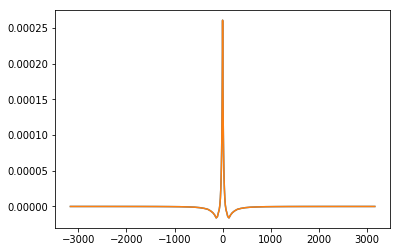

In [240]:
plt.plot(dchi_dchi[:,0], curly_Cl_mesh1[:,0])
plt.plot(dchi_dchi[:,0], curly_Cl_mesh2[:,0])

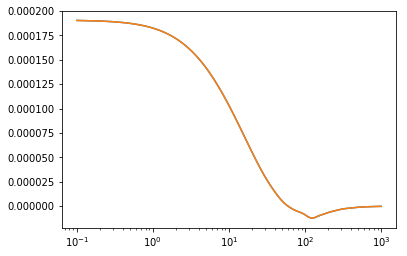

In [226]:
plt.semilogx(dchi_array,curly_C2_full_cluster_extra )
plt.semilogx(dchi_array,curly_C2_full_cluster )

In [301]:
curly_C2_full_cluster = curly_C_cluster(2, defcos.chi(2.0), dchi_array, c_n_array)
curly_C4_full_cluster = curly_C_cluster(4, defcos.chi(2.0), dchi_array, c_n_array)
curly_C6_full_cluster = curly_C_cluster(6, defcos.chi(2.0), dchi_array, c_n_array)
curly_C10_full_cluster = curly_C_cluster(10, defcos.chi(2.0), dchi_array, c_n_array)
curly_C100_full_cluster = curly_C_cluster(100, defcos.chi(2.0), dchi_array, c_n_array)
curly_C500_full_cluster = curly_C_cluster(500, defcos.chi(2.0), dchi_array, c_n_array)

(0, 2)

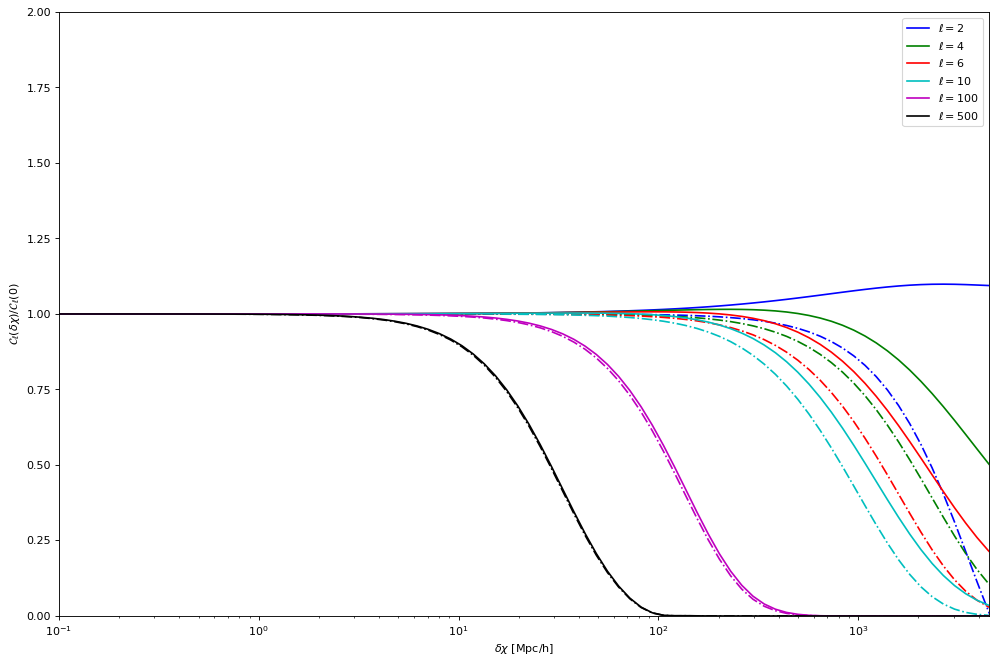

In [87]:
plt.figure(figsize=(15,10), dpi=80)
plt.semilogx(dchi_array, curly_C2_full,'-.' ,color = 'b')
plt.semilogx(dchi_array, curly_C4_full,'-.' ,color = 'g')
plt.semilogx(dchi_array, curly_C6_full,'-.' ,color = 'r')
plt.semilogx(dchi_array, curly_C10_full,'-.' ,color = 'c')
plt.semilogx(dchi_array, curly_C100_full,'-.' ,color = 'm')
plt.semilogx(dchi_array, curly_C500_full,'-.' ,color = 'k')

plt.semilogx(dchi_array, C2_lensing_array.real/C2_lensing_array[0].real,color = 'b',label=r'$\ell=2$')
plt.semilogx(dchi_array, C4_lensing_array.real/C4_lensing_array[0].real,color = 'g',label=r'$\ell=4$')
plt.semilogx(dchi_array, C6_lensing_array.real/C6_lensing_array[0].real,color = 'r',label=r'$\ell=6$')
plt.semilogx(dchi_array, C10_lensing_array.real/C10_lensing_array[0].real,color = 'c',label=r'$\ell=10$')
plt.semilogx(dchi_array, C100_lensing_array.real/C100_lensing_array[0].real,color = 'm',label=r'$\ell=100$')
plt.semilogx(dchi_array, C500_lensing_array.real/C500_lensing_array[0].real,color = 'k',label=r'$\ell=500$')

plt.legend()
plt.xlabel(r'$\delta\chi\rm\ [Mpc/h]$')
plt.ylabel(r'$\mathcal{C}_\ell(\delta\chi)/\mathcal{C}_\ell(0)$')
plt.xlim(1e-1,4500)
plt.ylim(0,2)

Text(0, 0.5, '$\\mathcal{C}_\\ell(\\delta\\chi)/\\mathcal{C}_\\ell(0)$')

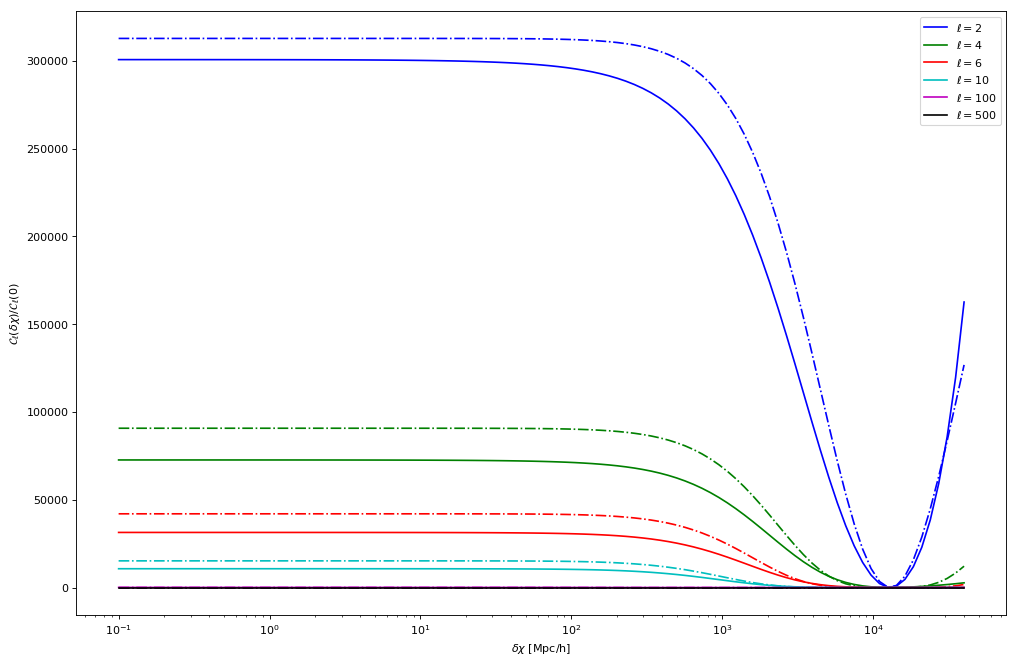

In [375]:
plt.figure(figsize=(15,10), dpi=80)

plt.semilogx(dchi_array, curly_C2_full,'-.' ,color = 'b')
plt.semilogx(dchi_array, curly_C4_full,'-.' ,color = 'g')
plt.semilogx(dchi_array, curly_C6_full,'-.' ,color = 'r')
plt.semilogx(dchi_array, curly_C10_full,'-.' ,color = 'c')
plt.semilogx(dchi_array, curly_C100_full,'-.' ,color = 'm')

plt.semilogx(dchi_array, curly_C500_full,'-.' ,color = 'k')
plt.semilogx(dchi_array, C2_lensing_array.real/chi**2,color = 'b',label=r'$\ell=2$')
plt.semilogx(dchi_array, C4_lensing_array.real/chi**2,color = 'g',label=r'$\ell=4$')
plt.semilogx(dchi_array, C6_lensing_array.real/chi**2,color = 'r',label=r'$\ell=6$')
plt.semilogx(dchi_array, C10_lensing_array.real/chi**2,color = 'c',label=r'$\ell=10$')
plt.semilogx(dchi_array, np.pi/2*C100_lensing_array.real/chi**2,color = 'm',label=r'$\ell=100$')
plt.semilogx(dchi_array, np.pi/2*C500_lensing_array.real/chi**2,color = 'k',label=r'$\ell=500$')

plt.legend()
plt.xlabel(r'$\delta\chi\rm\ [Mpc/h]$')
plt.ylabel(r'$\mathcal{C}_\ell(\delta\chi)/\mathcal{C}_\ell(0)$')
#plt.xlim(1e-1,4500)
#plt.ylim(0,2)

In [295]:
curly_C4_full_cluster

array([[ 7.80946599e-05,  7.80944485e-05,  7.80942166e-05, ...,
         6.26072414e-05,  6.13612625e-05,  6.00375763e-05],
       [ 7.80624834e-05,  7.80622716e-05,  7.80620394e-05, ...,
         6.25840406e-05,  6.13404214e-05,  6.00188599e-05],
       [ 7.80289115e-05,  7.80287002e-05,  7.80284685e-05, ...,
         6.25615897e-05,  6.13165965e-05,  5.99936476e-05],
       ...,
       [-2.03366299e-07, -2.03365208e-07, -2.03364011e-07, ...,
        -1.25477327e-07, -1.19840289e-07, -1.14044144e-07],
       [-1.59739310e-07, -1.59738315e-07, -1.59737224e-07, ...,
        -9.74976516e-08, -9.36509560e-08, -8.97569327e-08],
       [-1.21684074e-07, -1.21683351e-07, -1.21682557e-07, ...,
        -7.98940446e-08, -7.72533048e-08, -7.44959296e-08]])

Text(0, 0.5, '$\\mathcal{C}_\\ell(\\delta\\chi)/\\mathcal{C}_\\ell(0)$')

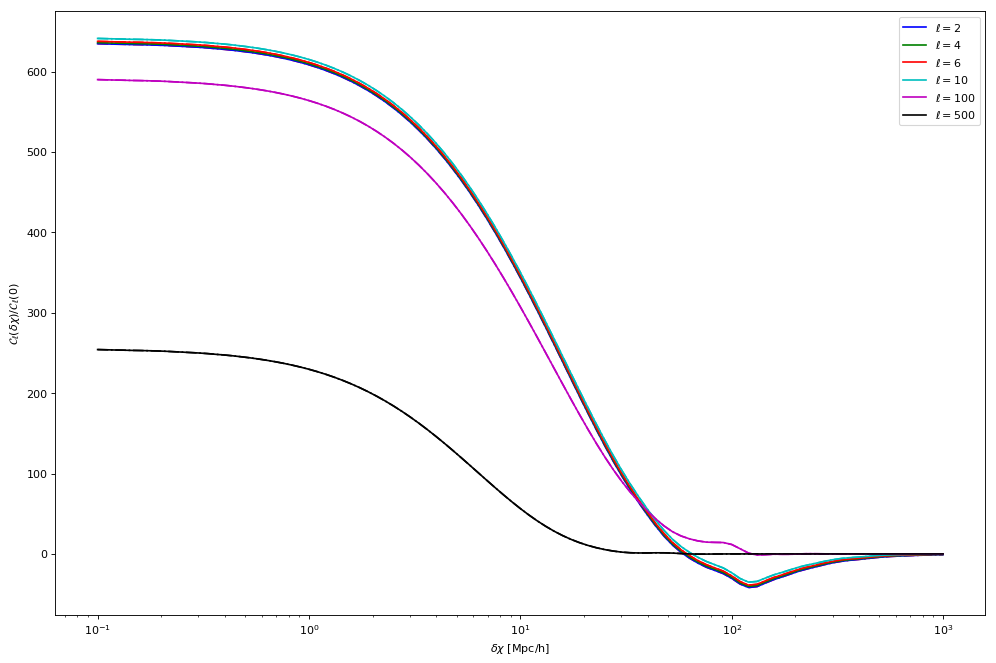

In [306]:
plt.semilogx(dchi_array, 2/np.pi*curly_C2_full_cluster*defcos.chi(2.0)**2,'-.' ,color = 'r')
plt.semilogx(dchi_array, 2/np.pi*curly_C4_full_cluster*defcos.chi(2.0)**2,'-.' ,color = 'g')
plt.semilogx(dchi_array, 2/np.pi*curly_C6_full_cluster*defcos.chi(2.0)**2,'-.' ,color = 'r')
plt.semilogx(dchi_array, 2/np.pi*curly_C10_full_cluster*defcos.chi(2.0)**2,'-.' ,color = 'c')
plt.semilogx(dchi_array, 2/np.pi*curly_C100_full_cluster*defcos.chi(2.0)**2,'-.' ,color = 'm')
plt.semilogx(dchi_array, 2/np.pi*curly_C500_full_cluster*defcos.chi(2.0)**2,'-.' ,color = 'k')

plt.semilogx(dchi_array, C2_special2_mod_array.real,color = 'b',label=r'$\ell=2$')
plt.semilogx(dchi_array, C4_special2_mod_array.real,color = 'g',label=r'$\ell=4$')
plt.semilogx(dchi_array, C6_special2_mod_array.real,color = 'r',label=r'$\ell=6$')
plt.semilogx(dchi_array, C10_special2_mod_array.real,color = 'c',label=r'$\ell=10$')
plt.semilogx(dchi_array, C100_special2_mod_array.real,color = 'm',label=r'$\ell=100$')
plt.semilogx(dchi_array, C500_special2_mod_array.real,color = 'k',label=r'$\ell=500$')

plt.legend()
plt.xlabel(r'$\delta\chi\rm\ [Mpc/h]$')
plt.ylabel(r'$\mathcal{C}_\ell(\delta\chi)/\mathcal{C}_\ell(0)$')

No handles with labels found to put in legend.


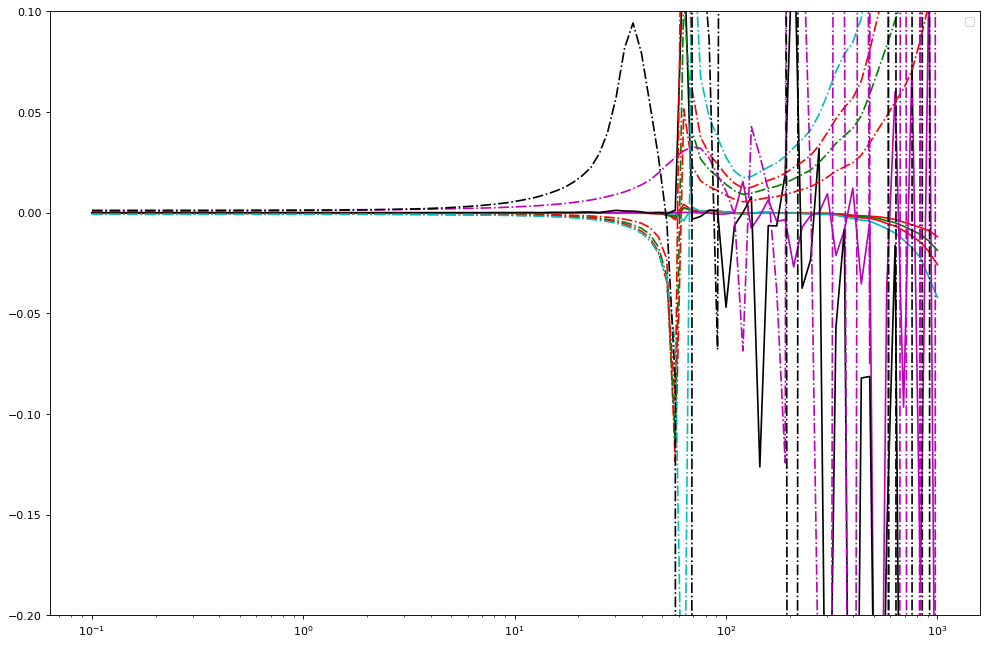

In [312]:
plt.figure(figsize=(15,10), dpi=80)
plt.semilogx(dchi_array, C2_special2_mod_array.real/(2/np.pi*curly_C2_full_cluster*defcos.chi(2.0)**2)-1,color = 'r')
plt.semilogx(dchi_array, C4_special2_mod_array.real/(2/np.pi*curly_C4_full_cluster*defcos.chi(2.0)**2)-1,color = 'g')
plt.semilogx(dchi_array, C6_special2_mod_array.real/(2/np.pi*curly_C6_full_cluster*defcos.chi(2.0)**2)-1,color = 'r')
plt.semilogx(dchi_array, C10_special2_mod_array.real/(2/np.pi*curly_C10_full_cluster*defcos.chi(2.0)**2)-1 ,color = 'c')
plt.semilogx(dchi_array, C100_special2_mod_array.real/(2/np.pi*curly_C100_full_cluster*defcos.chi(2.0)**2)-1,color = 'm')
plt.semilogx(dchi_array, C500_special2_mod_array.real/(2/np.pi*curly_C500_full_cluster*defcos.chi(2.0)**2)-1,color = 'k')

plt.semilogx(dchi_array, C2_special2_array.real/(2/np.pi*curly_C2_full_cluster*defcos.chi(2.0)**2)-1,'-.',color = 'r')
plt.semilogx(dchi_array, C4_special2_array.real/(2/np.pi*curly_C4_full_cluster*defcos.chi(2.0)**2)-1,'-.',color = 'g')
plt.semilogx(dchi_array, C6_special2_array.real/(2/np.pi*curly_C6_full_cluster*defcos.chi(2.0)**2)-1,'-.',color = 'r')
plt.semilogx(dchi_array, C10_special2_array.real/(2/np.pi*curly_C10_full_cluster*defcos.chi(2.0)**2)-1,'-.' ,color = 'c')
plt.semilogx(dchi_array, C100_special2_array.real/(2/np.pi*curly_C100_full_cluster*defcos.chi(2.0)**2)-1,'-.',color = 'm')
plt.semilogx(dchi_array, C500_special2_array.real/(2/np.pi*curly_C500_full_cluster*defcos.chi(2.0)**2)-1,'-.',color = 'k')

plt.ylim(-0.2,0.1)
plt.legend()



### Test the angular power spectrum caculation using M2i(x), instead of M1i(x):

In [318]:
l_Assassi = []
Cl_Assassi = []
Assassi_file_path = '/Users/cheng/Documents/Researches_at_Cambridge/Limber/1705 2/Mathematica/z1_2_z2_35.txt'
with open(Assassi_file_path,'r') as file:
    lines = file.readlines()
    for line in lines:
        l, C = line.split(',')
        l_Assassi.append(int(l))
        Cl_Assassi.append(float(C.strip('\n')))

file.close()
our_l = np.array(l_Assassi)

In [127]:
Cl_2_2 = full_calc_sampling1(our_l, 0, 1.0, 1.0, 0.05, 0.05, 50, 50, func_real_list2, func_imag_list2, c_n_array = c_n_array)

Time for preparing mesh-grids is: 9.514334201812744 s
Time for calculating each l is: 0.11245325829485338 s


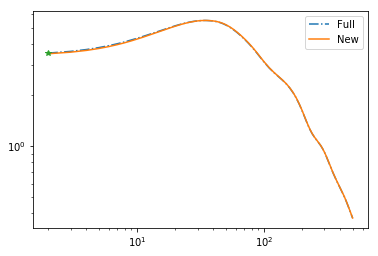

In [247]:
#plt.loglog(our_l, Cl_2_2*1e6,label=r'Old')
plt.loglog(our_l, np.array(Cl_Assassi)*1e6,'-.',label=r'Full')
plt.loglog(our_l, Cl11_chi_dchi*1e6,label=r'New')
plt.loglog([2], C2_full*1e6,'*')
plt.legend()

In [461]:
from scipy.interpolate import interp1d
def plot_compare(path_Aassassi, path_Limber, our_l, our_Cl, our_Cl_mod, delta, ymin, ymax, xmin, xmax, rescale):

    l_Assassi = []
    Cl_Assassi = []
    with open(path_Aassassi,'r') as file:
        lines = file.readlines()
        for line in lines:
            l, C = line.split(',')
            l_Assassi.append(int(l))
            Cl_Assassi.append(float(C.strip('\n')))

    file.close()

    l_limber = np.load(path_Limber)[0,:]
    Cl_limber = np.load(path_Limber)[1,:]
    fig, axes = plt.subplots(2,1, figsize=(10,8), sharex=True, gridspec_kw={'height_ratios': [3, 1],'hspace':0.05})
    ax0,ax1 = axes[0],axes[1]
    #frame1 = fig.add_axes((.2, .4, .8, .8))  
    l_prime = (np.sqrt(1+4*our_l**2*(1-1*delta**2)**1))/2-1/2 
    amp_factor = (1-delta**2)
    
    ax0.plot(our_l, np.abs(np.array(our_Cl))*rescale, color = 'r', label=r'OurApprox')
    ax0.plot(our_l, np.abs(np.array(our_Cl_mod))*rescale, color = 'g', label=r'OurApprox Modified')
    ax0.plot(l_limber, np.abs(Cl_limber)*rescale, '--', color = 'b', label=r'Limber')
    #ax0.plot(l_prime, np.abs(np.array(our_Cl))*rescale, color = 'g', label=r'OurApprox Modified')
    ax0.plot(l_Assassi, np.abs(np.array(Cl_Assassi))*rescale,'-.', color = 'k', label=r'FullSky')
    '''
    ax0.plot(our_l, np.array(our_Cl)*rescale, color = 'r', label=r'OurApprox')
    ax0.plot(l_prime, np.array(our_Cl)*rescale, color = 'g', label=r'OurApprox Modified')
    #ax0.plot((np.sqrt(1+4*our_l**2))/2-1/2, np.array(our_Cl)*rescale, '-.' ,color = 'g',label=r'OurApprox Modified')
    ax0.plot(l_limber, Cl_limber*rescale, '--', color = 'b', label=r'Limber')
    ax0.plot(l_Assassi, np.array(Cl_Assassi)*rescale,'-.', color = 'k', label=r'FullSky')
    '''
    ax0.set_xscale('log')
    ax0.set_yscale('log')
    ax0.set_ylim(ymin, ymax)
    ax0.set_xlim(xmin, xmax)
    ax0.legend()
    #ax0.xlabel(r'$\ell$',fontsize=15)
    ax0.set_ylabel(r'$C_{\ell}^{g}\ (\times 10^{%d})$'%np.log10(rescale), fontsize=15)
    ax0.tick_params(labelsize=15)
    #frame1.set_xticklabels([])
    #ax0.tight_layout()
    plt.setp(ax0.get_xticklabels(), visible=False)
    #frame2 = fig.add_axes((.2, .2, .8, .3))
    ax1.plot(our_l, (our_Cl/Cl_Assassi-1)*100, color='r')
    ax1.plot(our_l, (our_Cl_mod/Cl_Assassi-1)*100, color='g')
    #Reconstruct the error of modified power spectrum
    '''
    func_mod = interp1d(l_prime, our_Cl)
    l_min = l_prime.min()
    l_max = l_prime.max()
    bw = (our_l>l_min) & (our_l<l_max)
    Cl_mod = func_mod(our_l[bw])
    ax1.plot(our_l[bw], (Cl_mod/np.array(Cl_Assassi)[bw]-1)*100, color='g')
    #ax1.plot(our_l[:-1], (Cl_limber/np.array(Cl_Assassi)[:-1]-1)*100,'--', color='b')
    '''
    ax1.plot(our_l[:-1], (Cl_limber/np.array(Cl_Assassi)[:-1]-1)*100,'--', color='b')
    ax1.plot(our_l, [0. for i in range(len(our_l))],'-.', color='k')
    
    ax1.set_xscale('log')
    ax1.set_ylim(-20, 20)
    ax1.set_xlim(xmin, xmax)
    ax1.tick_params(axis='both', labelsize=15)
    ax1.set_xlabel(r'$\ell$',fontsize=15)
    ax1.set_ylabel(r'$\rm Ratio-1\,[\%]$',fontsize=15)

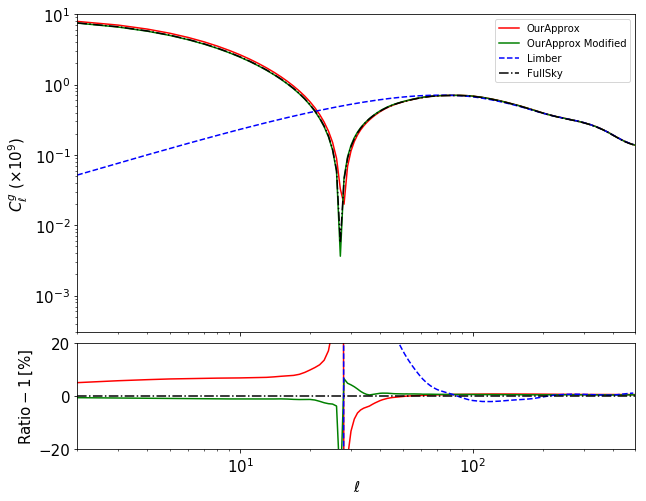

In [610]:
plot_compare('/Users/cheng/Documents/Researches_at_Cambridge/Limber/1705 2/Mathematica/z1_2_z2_35.txt',\
    './Limber/z1_2_z2_35_03.npy', np.array(our_l), Cl235_chi_dchi_new, Cl235_chi_dchi_mod ,0, 0.0003, 10, 2, 500, 1e9)

#plt.savefig('./Cl_data/Plots/Cl_2_35.pdf', dpi=200)

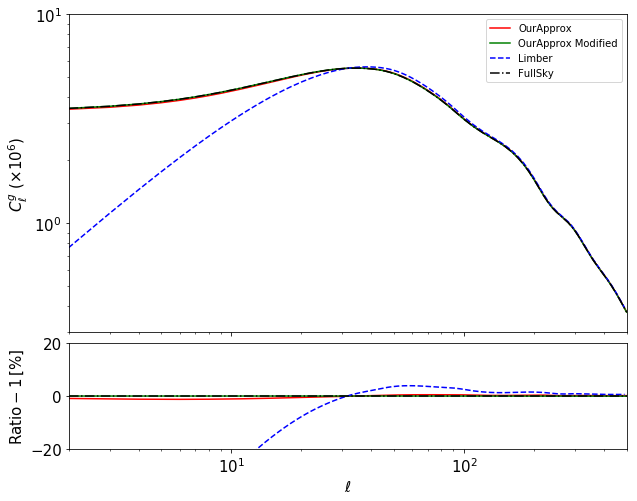

In [614]:
plot_compare('/Users/cheng/Documents/Researches_at_Cambridge/Limber/1705 2/Mathematica/z1_1_z2_1.txt',\
    './Limber/z1_1_z2_1_005.npy', np.array(our_l), Cl11_chi_dchi_new, Cl11_chi_dchi_new_mod1, 0, 0.3, 10, 2, 500, 1e6)

#plt.savefig('./Cl_data/Plots/Cl_1_1.pdf', dpi=200)

### With the same procedure, we try to use the sampling and integration over $\chi_1$ and $\chi_2$, instead of $\bar{chi}$ and $\delta\chi$, to avoid negative comoving distance issue.

In [270]:
def Wg( chi, chi_avg, chi_sigma):
        '''
        Here we consider a Gaussian window function
        '''
        term1 = 1/(np.sqrt(2*np.pi))/chi_sigma
        term2 = np.exp(-(chi-chi_avg)**2/(2*chi_sigma**2))
        return term1*term2

def mesh_grid_generator2(z1, z2, sigma1, sigma2, Nchi1, Nchi2):
        '''
        Params:
        z1, z2: the redshifts of our objects
        sigma1, sigma2: the dispersion of our window function
        Nchi1, Nchi2: fidicually chosen length of the sampling array of chi1 and chi2

        Return:
        mesh-grids of chi1_chi1, chi2_chi2, 
        and, growth factors D1_D1, D2_D2.
        '''
        chi_avg1 = defcos.chi(z1)
        chi_avg2 = defcos.chi(z2)
        chi_sigma1 = sigma1/defcos.HH(z1)
        chi_sigma2 = sigma2/defcos.HH(z2)
        chi1_min = max(chi_avg1-4*chi_sigma1, 0.3)
        chi1_max = chi_avg1+4*chi_sigma1
        chi2_min = max(chi_avg2-3.5*chi_sigma2, 0.5)
        chi2_max = chi_avg2+3.5*chi_sigma2
        chi1_array = np.array([chi1_min + i*(chi1_max-chi1_min)/Nchi1 for i in range(Nchi1)])
        chi2_array = np.array([chi2_min + i*(chi2_max-chi2_min)/Nchi2 for i in range(Nchi2)])
        
        #Create the sample grid
        D1_array = np.array([defcos.Dg_norm(chi1) for chi1 in chi1_array])
        D2_array = np.array([defcos.Dg_norm(chi2) for chi2 in chi2_array])
        D1_D1, D2_D2 = np.meshgrid(D1_array, D2_array)
        chi1_chi1, chi2_chi2 = np.meshgrid(chi1_array, chi2_array)
        
        Wg1_Wg1 = Wg(chi1_chi1, chi_avg1, chi_sigma1)
        Wg2_Wg2 = Wg(chi2_chi2, chi_avg2, chi_sigma2)

        return chi1_chi1, chi2_chi2, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2

#############################################################################################################
def power_calc_sampling2(l, n, chi1_chi1, chi2_chi2, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, c_n_array):
    '''
    Params:
    l: The multiple
    n: The order of our approximation, usually order 0 will be good enough
    chi_chi, dchi_dchi: The 2D mesh-grid of the chi (dchi) parameter. 
                        The n_row is the same as length of dchi array, 
                        while the n_columns is the same as length of chi array.
    D1_D1, D2_D2: The mesh-grid of growth factor. The same shape as chi_chi.
    Wg1_Wg1, Wg2_Wg2: The mesh-grid of several window functions.

    Return:
    The angular power spetrum at mutiple l.
    '''
    dchi_dchi = chi2_chi2-chi1_chi1
    bw = (dchi_dchi==0.)
    xx = dchi_dchi *l/chi2_chi2 
    l_tilde = l/chi2_chi2
    Cl_array_array = np.array([ (c_n_array[i]*(func_real_list2[i](np.abs(xx))+1j*func_imag_list2[i](np.abs(xx))))*\
        np.abs(l_tilde)**(nu_n_array[i]+1) for i in range(int(Nmax)+1)])
    '''
    Cl_array_array = np.array([ (c_n_array[i]*(func_real_list[i](np.abs(xx))+1j*func_imag_list[i](np.abs(xx))))*\
        np.abs(dchi_dchi)**(-nu_n_array[i]-1) for i in range(int(Nmax)+1)])
    '''
    #Cl_array_array[np.isnan(Cl_array_array)]=0.
    Cl_array = np.sum(Cl_array_array, axis=0)

    Simp_array = D1_D1*D2_D2*Cl_array*Wg1_Wg1*Wg2_Wg2*4/(chi1_chi1+chi2_chi2)**2
    #Simp_array = D1_D1*D2_D2*Cl_array*Wg1_Wg1*Wg2_Wg2*(dchi_dchi/chi_chi)**n/chi_chi**2
    results = simps(simps(Simp_array, chi1_chi1[0, :]), chi2_chi2[:, 0])
    return results

def full_calc_sampling2(l_array, n, z1, z2, sigma1, sigma2, Nchi, Ndchi, c_n_array = c_n_array):
    '''
    Params:
    l_array: The array of multiples we have chosen to consider
    The meaning of rest parameters could be found above
    c_n_array: the decomposed coefficients array

    Return:
    An list of angular power spectrum given l_array
    '''
    start1 = time.time()
    chi1_chi1, chi2_chi2, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2 = mesh_grid_generator2(z1, z2, sigma1, sigma2, Nchi, Ndchi)
    end1 = time.time()-start1
    print('Time for preparing mesh-grids is:', end1, 's')
    start2 = time.time()
    power_array = [power_calc_sampling2(li, n, chi1_chi1, chi2_chi2, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, c_n_array).real for li in l_array]
    end2 = (time.time()-start2)/len(l_array)
    print('Time for calculating each l is:', end2, 's')

    return np.array(power_array)

### Here we try to build up the resampling method using $\bar{\chi}$ and $\delta\chi$ whose range is self-adapting

In [943]:
def Wg( chi, chi_avg, chi_sigma):
        '''
        Here we consider a Gaussian window function
        '''
        term1 = 1/(np.sqrt(2*np.pi))/chi_sigma
        term2 = np.exp(-(chi-chi_avg)**2/(2*chi_sigma**2))
        return term1*term2

def mesh_grid_generator3(z1, z2, sigma1, sigma2, Nchi, Ndchi):
        '''
        Params:
        z1, z2: the redshifts of our objects
        sigma1, sigma2: the dispersion of our window function
        Nchi, Ndchi: fidicually chosen length of the sampling array of chi and dchi

        Return:
        mesh-grids of chi1_chi1, chi2_chi2, 
        and, growth factors D1_D1, D2_D2.
        '''
        chi_avg1 = defcos.chi(z1)
        chi_avg2 = defcos.chi(z2)
        chi_sigma1 = sigma1/defcos.HH(z1)
        chi_sigma2 = sigma2/defcos.HH(z2)
        chi_min = max(100, chi_avg1-4*chi_sigma1)
        chi_max = min(defcos.chi(1100), chi_avg2+chi_sigma2*4)
        chi_array = np.array([chi_min + i*(chi_max-chi_min)/Nchi for i in range(Nchi)])
        dchi_basline = np.arange(2*Ndchi)
        D1_D1 = np.zeros((2*Ndchi, Nchi))
        D2_D2 = np.zeros((2*Ndchi, Nchi))

        chi_chi, dchi_dchi_raw = np.meshgrid(chi_array, dchi_basline)
        dchi_dchi_list = []
        for i in range(Nchi):
            dchi_max = min(2*chi_array[i], 2*(defcos.chi(1110)-chi_array[i]))
            dchi_array = list(-10**np.array([-1+(np.log10(dchi_max-1)+1)/Ndchi*j for j in range(Ndchi)])[::-1])\
                +list(10**np.array([-1+(np.log10(dchi_max-1)+1)/Ndchi*j for j in range(Ndchi)]))
            dchi_dchi_list.append(dchi_array)
        dchi_dchi = np.transpose(np.array(dchi_dchi_list))
        print(np.shape(chi_chi), np.shape(dchi_dchi))
        grid1 = chi_chi-0.5*dchi_dchi
        grid2 = chi_chi+0.5*dchi_dchi
        
        for i in range(len(chi_array)):
            for j in range(len(dchi_basline)):
                grid1_ji = grid1[j,i]
                grid2_ji = grid2[j,i]
                D1_D1[j, i] = defcos.Dg_norm(grid1_ji)
                D2_D2[j, i] = defcos.Dg_norm(grid2_ji)

        Wg1_Wg1 = Wg(grid1, chi_avg1, chi_sigma1)
        Wg2_Wg2 = Wg(grid2, chi_avg2, chi_sigma2)

        return chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2

#############################################################################################################
def power_calc_sampling3(l, n, chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, c_n_array):
    '''
    Params:
    l: The multiple
    n: The order of our approximation, usually order 0 will be good enough
    chi_chi, dchi_dchi: The 2D mesh-grid of the chi (dchi) parameter. 
                        The n_row is the same as length of dchi array, 
                        while the n_columns is the same as length of chi array.
    D1_D1, D2_D2: The mesh-grid of growth factor. The same shape as chi_chi.
    Wg1_Wg1, Wg2_Wg2: The mesh-grid of several window functions.

    Return:
    The angular power spetrum at mutiple l.
    '''
    xx = dchi_dchi *l/(chi_chi)/np.sqrt(1-(dchi_dchi/2/chi_chi)**2)#+0.5*dchi_dchi)
    l_tilde = l/(chi_chi)/np.sqrt(1-(dchi_dchi/2/chi_chi)**2)#+0.5*dchi_dchi)
    Cl_array_array = np.array([ (c_n_array[i]*(func_real_list2[i](np.abs(xx))+1j*func_imag_list2[i](np.abs(xx))))*\
        np.abs(l_tilde)**(nu_n_array[i]+1) for i in range(int(Nmax)+1)])
    '''
    Cl_array_array = np.array([ (c_n_array[i]*(func_real_list[i](np.abs(xx))+1j*func_imag_list[i](np.abs(xx))))*\
        np.abs(dchi_dchi)**(-nu_n_array[i]-1) for i in range(int(Nmax)+1)])
    '''
    #Cl_array_array[np.isnan(Cl_array_array)]=0.
    Cl_array = np.sum(Cl_array_array, axis=0)

    Simp_array = D1_D1*D2_D2*Cl_array*Wg1_Wg1*Wg2_Wg2/(chi_chi)**2
    #Simp_array = D1_D1*D2_D2*Cl_array*Wg1_Wg1*Wg2_Wg2*(dchi_dchi/chi_chi)**n/chi_chi**2
    intover_dchi = np.array([simps(Simp_array[:,i], dchi_dchi[:,i]) for i in range(len(chi_chi[0,:]))])
    results = simps(intover_dchi, chi_chi[0, :])
    return results

def full_calc_sampling3(l_array, n, z1, z2, sigma1, sigma2, Nchi, Ndchi, c_n_array = c_n_array):
    '''
    Params:
    l_array: The array of multiples we have chosen to consider
    The meaning of rest parameters could be found above
    c_n_array: the decomposed coefficients array

    Return:
    An list of angular power spectrum given l_array
    '''
    start1 = time.time()
    chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2 = mesh_grid_generator3(z1, z2, sigma1, sigma2, Nchi, Ndchi)
    end1 = time.time()-start1
    print('Time for preparing mesh-grids is:', end1, 's')
    start2 = time.time()
    power_array = [power_calc_sampling3(li, n, chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, c_n_array).real for li in l_array]
    end2 = (time.time()-start2)/len(l_array)
    print('Time for calculating each l is:', end2, 's')

    return np.array(power_array)

### Here we test the modification based on Anthony's derivation:

In [940]:
def power_calc_sampling3_mod(l, n, chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, c_n_array):
    '''
    Params:
    l: The multiple
    n: The order of our approximation, usually order 0 will be good enough
    chi_chi, dchi_dchi: The 2D mesh-grid of the chi (dchi) parameter. 
                        The n_row is the same as length of dchi array, 
                        while the n_columns is the same as length of chi array.
    D1_D1, D2_D2: The mesh-grid of growth factor. The same shape as chi_chi.
    Wg1_Wg1, Wg2_Wg2: The mesh-grid of several window functions.

    Return:
    The angular power spetrum at mutiple l.
    '''
    #xx = dchi_dchi *np.sqrt(l*(l+1))/(chi_chi+0.5*dchi_dchi)/(1-(dchi_dchi/2/chi_chi))
    #l_tilde = np.sqrt(l*(l+1))/(chi_chi+0.5*dchi_dchi)/(1-(dchi_dchi/2/chi_chi))

    xx = dchi_dchi *np.sqrt(l*(l+1))/(chi_chi)/np.sqrt(1-(dchi_dchi/2/chi_chi)**2)
    l_tilde = np.sqrt(l*(l+1))/(chi_chi)/np.sqrt(1-(dchi_dchi/2/chi_chi)**2)
    Cl_array_array = np.array([ (c_n_array[i]*(func_real_list2[i](np.abs(xx))+1j*func_imag_list2[i](np.abs(xx))))*\
        np.abs(l_tilde)**(nu_n_array[i]+1) for i in range(int(Nmax)+1)])
    '''
    Cl_array_array = np.array([ (c_n_array[i]*(func_real_list[i](np.abs(xx))+1j*func_imag_list[i](np.abs(xx))))*\
        np.abs(dchi_dchi)**(-nu_n_array[i]-1) for i in range(int(Nmax)+1)])
    '''
    #Cl_array_array[np.isnan(Cl_array_array)]=0.
    Cl_array = np.sum(Cl_array_array, axis=0)#*(1+3*(dchi_dchi/2/chi_chi)**2)

    Simp_array = D1_D1*D2_D2*Cl_array*Wg1_Wg1*Wg2_Wg2/(chi_chi)**2
    #Simp_array = D1_D1*D2_D2*Cl_array*Wg1_Wg1*Wg2_Wg2*(dchi_dchi/chi_chi)**n/chi_chi**2
    intover_dchi = np.array([simps(Simp_array[:,i], dchi_dchi[:,i]) for i in range(len(chi_chi[0,:]))])
    results = simps(intover_dchi, chi_chi[0, :])
    return results

def full_calc_sampling3_mod(l_array, n, z1, z2, sigma1, sigma2, Nchi, Ndchi, c_n_array = c_n_array):
    '''
    Params:
    l_array: The array of multiples we have chosen to consider
    The meaning of rest parameters could be found above
    c_n_array: the decomposed coefficients array

    Return:
    An list of angular power spectrum given l_array
    '''
    start1 = time.time()
    chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2 = mesh_grid_generator3(z1, z2, sigma1, sigma2, Nchi, Ndchi)
    end1 = time.time()-start1
    print('Time for preparing mesh-grids is:', end1, 's')
    start2 = time.time()
    power_array = [power_calc_sampling3_mod(li, n, chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, c_n_array).real for li in l_array]
    end2 = (time.time()-start2)/len(l_array)
    print('Time for calculating each l is:', end2, 's')

    return np.array(power_array)

In [ ]:
from scipy.integrate import quad
def Pk_potent1(kh):

    return defcos.Plin(kh)/kh**0

def Power_spectrum1(kh_par, l, chi, dchi):

    kh = np.sqrt(kh_par**2 + (l/chi/np.sqrt(1-(0.5*dchi/chi)**2))**2)

    return Pk_potent1(kh)

def Kernel_Limber(l, chi, chi_avg1, chi_sigma1, chi_avg2, chi_sigma2):
    
    W1 = Wg(chi, chi_avg1, chi_sigma1)
    W2 = Wg(chi, chi_avg2, chi_sigma2)
    D1 = defcos.Dg_norm(chi)
    C = Power_spectrum1(kh_par=0, l=l, chi=chi, dchi=0)
    return D1*D1*W1*W2*C
    
def Cn_Limber(l, chi_avg1, chi_sigma1, chi_avg2, chi_sigma2, chi_min, chi_max):

    def integrand(chi):
        return Kernel_Limber(l,chi, chi_avg1, chi_sigma1, chi_avg2, chi_sigma2)/(chi**2)
    
    return quad(integrand, chi_min, chi_max)[0]

#C_77_limber = [Cn_Limber(li, defcos.chi(1.0), 0.7/defcos.HH(1.0), defcos.chi(1.0), 0.7/defcos.HH(1.0), 0.1, 7000) for li in our_l]

In [891]:
chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2 = mesh_grid_generator3(2.0, 2.0, 0.3, 0.3, 50, 50)

np.save('./Mesh_22', [chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2])

(100, 50) (100, 50)


In [230]:
chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2 = mesh_grid_generator3(1.0, 1.0, 0.05, 0.05, 50, 50)
xx = dchi_dchi * 2/(chi_chi+0.5*dchi_dchi)
print(np.abs(xx).min())
print(np.abs(xx).max())

(100, 50) (100, 50)
7.656605796269253e-05
16.96167322236299


In [950]:
Cl11_chi_dchi_1 = full_calc_sampling3(our_l, 0, 1.0, 1.0, 0.05, 0.05, 50, 50, c_n_array)
Cl11_chi_dchi_2 = full_calc_sampling3_mod(our_l, 0, 1.0, 1.0, 0.05, 0.05, 50, 50, c_n_array)

(100, 50) (100, 50)
Time for preparing mesh-grids is: 11.510123014450073 s
Time for calculating each l is: 0.13359769128209395 s
(100, 50) (100, 50)
Time for preparing mesh-grids is: 9.315519094467163 s
Time for calculating each l is: 0.1281966631361049 s


In [952]:
Cl22_chi_dchi_1 = full_calc_sampling3(our_l, 0, 2.0, 2.0, 0.3, 0.3, 50, 50, c_n_array)
Cl22_chi_dchi_2 = full_calc_sampling3_mod(our_l, 0, 2.0, 2.0, 0.3, 0.3, 50, 50, c_n_array)

(100, 50) (100, 50)
Time for preparing mesh-grids is: 10.161638975143433 s
Time for calculating each l is: 0.1221812303117711 s
(100, 50) (100, 50)
Time for preparing mesh-grids is: 9.021730899810791 s
Time for calculating each l is: 0.11768841743469238 s


In [ ]:
C11_005_limber = np.array([Cn_Limber(li, defcos.chi(1.0) , 0.05/defcos.HH(1.0), defcos.chi(1.0), 0.05/defcos.HH(1.0), 0.1, 5000) for li in our_l])
C22_03_limber = np.array([Cn_Limber(li, defcos.chi(2.0) , 0.3/defcos.HH(2.0), defcos.chi(2.0), 0.3/defcos.HH(2.0), 0.1, 5000) for li in our_l])

In [ ]:
C235_03_limber = np.array([Cn_Limber(li, defcos.chi(2.0) , 0.3/defcos.HH(2.0), defcos.chi(3.5), 0.3/defcos.HH(3.5), 0.1, 7000) for li in our_l])

In [ ]:
C1125_005_limber = np.array([Cn_Limber(li, defcos.chi(1.0) , 0.05/defcos.HH(1.0), defcos.chi(1.25), 0.05/defcos.HH(1.25), 0.1, 5000) for li in our_l])

In [612]:
Cl11_chi_dchi_new_mod1 = full_calc_sampling3_mod(our_l, 0, 1.0, 1.0, 0.05, 0.05, 50, 50, c_n_array)

(100, 50) (100, 50)
Time for preparing mesh-grids is: 9.045989274978638 s
Time for calculating each l is: 0.11529053372444867 s


In [615]:
Cl235_chi_dchi_1 = full_calc_sampling3(our_l, 0, 2.0, 3.5, 0.3, 0.3, 50, 50, c_n_array)

(100, 50) (100, 50)
Time for preparing mesh-grids is: 9.902997970581055 s
Time for calculating each l is: 0.1236735333641656 s


In [618]:
Cl235_chi_dchi_2 = full_calc_sampling3_mod(our_l, 0, 2.0, 3.5, 0.3, 0.3, 50, 50, c_n_array)

(100, 50) (100, 50)
Time for preparing mesh-grids is: 9.356899738311768 s
Time for calculating each l is: 0.1201341735373298 s


In [620]:
Cl235_chi_dchi_3 = full_calc_sampling3_mod(our_l, 0, 2.0, 3.5, 0.3, 0.3, 50, 50, c_n_array)

(100, 50) (100, 50)
Time for preparing mesh-grids is: 9.204920053482056 s
Time for calculating each l is: 0.12201587930857706 s


In [941]:
Cl235_chi_dchi_4 = full_calc_sampling3_mod(our_l, 0, 2.0, 3.5, 0.3, 0.3, 50, 50, c_n_array)

(100, 50) (100, 50)
Time for preparing mesh-grids is: 9.099644899368286 s
Time for calculating each l is: 0.11771200029112452 s


In [624]:
Cl235_chi_dchi_5 = full_calc_sampling3_mod(our_l, 0, 2.0, 3.5, 0.3, 0.3, 50, 50, c_n_array)

(100, 50) (100, 50)
Time for preparing mesh-grids is: 9.181257963180542 s
Time for calculating each l is: 0.12117410735260668 s


In [685]:
Cl235_chi_dchi_7 = full_calc_sampling3_mod(our_l, 0, 2.0, 3.5, 0.3, 0.3, 50, 50, c_n_array)

(100, 50) (100, 50)
Time for preparing mesh-grids is: 9.165295839309692 s
Time for calculating each l is: 0.11616951784641623 s


In [944]:
Cl1125_chi_dchi_1 = full_calc_sampling3_mod(our_l, 0, 1.0, 1.25, 0.05, 0.05, 50, 50, c_n_array)

(100, 50) (100, 50)
Time for preparing mesh-grids is: 9.301758050918579 s
Time for calculating each l is: 0.11534305785199721 s


In [867]:
Cl1125_chi_dchi_2 = full_calc_sampling3_mod(our_l, 0, 1.0, 1.25, 0.05, 0.05, 50, 50, c_n_array)

(100, 50) (100, 50)
Time for preparing mesh-grids is: 9.21764087677002 s
Time for calculating each l is: 0.12542020845756258 s


In [869]:
Cl1125_chi_dchi_3 = full_calc_sampling3_mod(our_l, 0, 1.0, 1.25, 0.05, 0.05, 50, 50, c_n_array)

(100, 50) (100, 50)
Time for preparing mesh-grids is: 10.533655166625977 s
Time for calculating each l is: 0.1337066897385412 s


Text(0, 0.5, '$\\rm Ratio-1\\,[\\%]$')

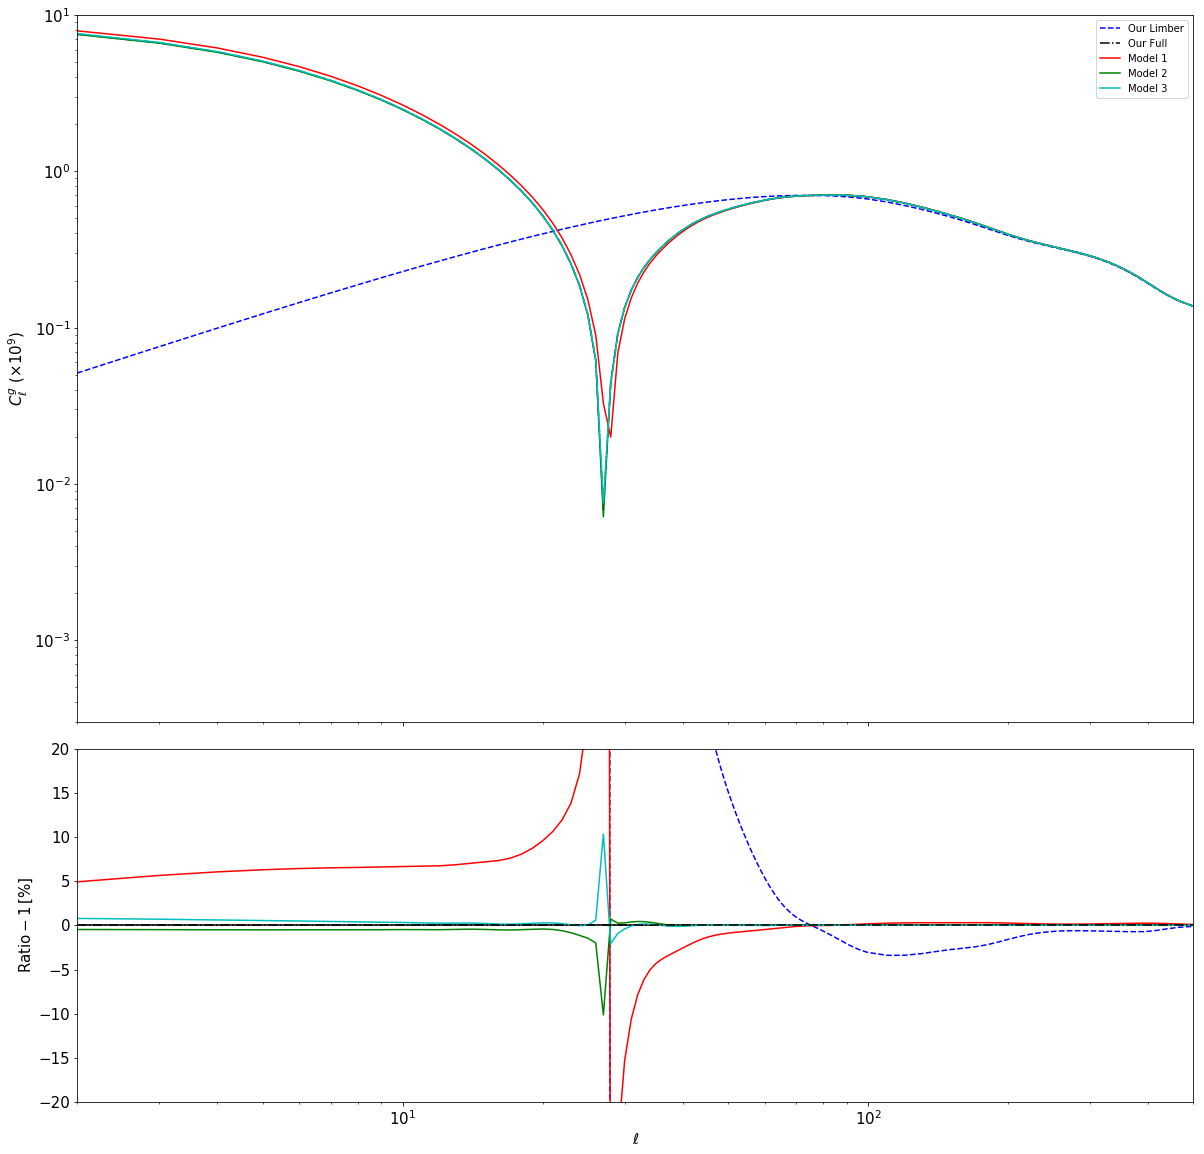

In [948]:

Cl235_full = np.loadtxt('./Full-sky/Cl_235_number.txt')[:,1]
fig, axes = plt.subplots(2,1, figsize=(20,20), sharex=True, gridspec_kw={'height_ratios': [2, 1],'hspace':0.05})
ax0,ax1 = axes[0],axes[1]

#ax0.plot(our_l, np.abs(Cl_Assassi)*1e9,'-.' , color='k',label=r'Full Sky')
#ax0.plot(our_l, np.abs(Cl_Assassi_limber)*1e9,'--' , color='k',label=r'Assassi Limber')
ax0.plot(our_l, np.abs(C235_03_limber)*1e9,'--' , color='b',label=r'Our Limber')
ax0.plot(our_l, np.abs(Cl235_full)*1e9, '-.',color = 'k', markersize=15, label=r'Our Full')
ax0.plot(our_l, np.abs(Cl235_chi_dchi_1)*1e9,color='r' ,label=r'Model 1')
ax0.plot(our_l, np.abs(Cl235_chi_dchi_2)*1e9,color='g' , label=r'Model 2')
ax0.plot(our_l, np.abs(Cl235_chi_dchi_3)*1e9,color='c' , label=r'Model 3')
#ax0.plot(our_l, np.abs(Cl235_chi_dchi_4)*1e9,color='m' , label=r'Model 4')
#ax0.plot(our_l, np.abs(Cl235_chi_dchi_5)*1e9,color='y' , label=r'Model 5')
#ax0.plot(our_l, np.abs(Cl235_chi_dchi_7)*1e9,color='b' , label=r'Model 7')

ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_ylim(0.0003, 10)
ax0.set_xlim(2, 500)
ax0.legend()
#ax0.xlabel(r'$\ell$',fontsize=15)
ax0.set_ylabel(r'$C_{\ell}^{g}\ (\times 10^{%d})$'%np.log10(1e9), fontsize=15)
ax0.tick_params(labelsize=15)
plt.setp(ax0.get_xticklabels(), visible=False)


ax1.plot(our_l, (C235_03_limber/Cl235_full-1)*1e2,'--',color='b')
#ax1.plot(our_l, (Cl_Assassi_limber/Cl_Assassi-1)*1e2,'--',color='k')
ax1.plot(our_l, (Cl235_full/Cl235_full-1)*1e2,'-',color='k',markersize=15)
ax1.plot(our_l, (Cl235_chi_dchi_1/Cl235_full-1)*1e2,color='r')
ax1.plot(our_l, (Cl235_chi_dchi_2/Cl235_full-1)*1e2,color='g')
ax1.plot(our_l, (Cl235_chi_dchi_3/Cl235_full-1)*1e2,color='c')
#ax1.plot(our_l, (Cl235_chi_dchi_4/Cl235_full-1)*1e2,color='m')
#ax1.plot(our_l, (Cl235_chi_dchi_5/Cl_Assassi-1)*1e2,color='y')
#ax1.plot(our_l, (Cl235_chi_dchi_7/Cl_Assassi-1)*1e2,color='b')

ax1.plot(our_l, [0. for i in range(len(our_l))],'-.', color='k')
    
ax1.set_xscale('log')
ax1.set_ylim(-20, 20)
ax1.set_xlim(2, 500)
ax1.tick_params(axis='both', labelsize=15)
ax1.set_xlabel(r'$\ell$',fontsize=15)
ax1.set_ylabel(r'$\rm Ratio-1\,[\%]$',fontsize=15)

Text(0, 0.5, '$\\rm Ratio-1\\,[\\%]$')

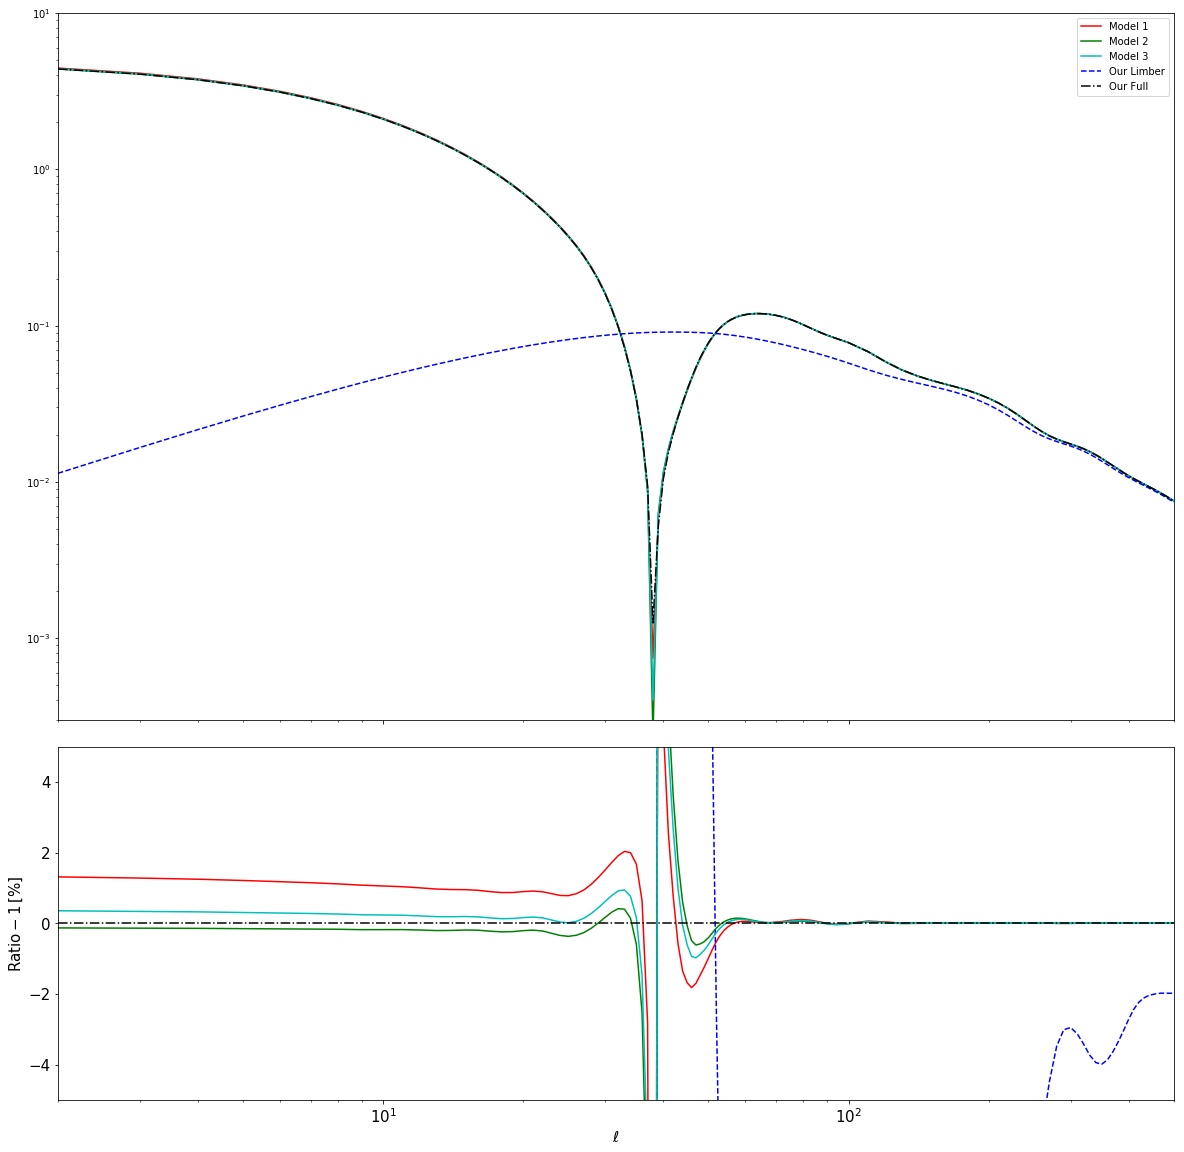

In [949]:

Cl1125_full = np.loadtxt('./Full-sky/Cl_1125_number.txt')[:,1]
fig, axes = plt.subplots(2,1, figsize=(20,20), sharex=True, gridspec_kw={'height_ratios': [2, 1],'hspace':0.05})
ax0,ax1 = axes[0],axes[1]

ax0.plot(our_l, np.abs(Cl1125_chi_dchi_1)*1e7, color='r',label=r'Model 1')
ax0.plot(our_l, np.abs(Cl1125_chi_dchi_2)*1e7, color='g' , label=r'Model 2')
ax0.plot(our_l, np.abs(Cl1125_chi_dchi_3)*1e7, color='c' , label=r'Model 3')
ax0.plot(our_l, np.abs(C1125_005_limber)*1e7,'--' , color='b',label=r'Our Limber')
ax0.plot(our_l, np.abs(Cl1125_full)*1e7,'-.', color='k', label=r'Our Full' )
ax0.legend()
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_ylim(0.0003, 10)
ax0.set_xlim(2, 500)

ax1.plot(our_l, (Cl1125_chi_dchi_1/Cl1125_full-1)*1e2,color='r')
ax1.plot(our_l, (C1125_005_limber/Cl1125_full-1)*1e2,'--',color='b')
ax1.plot(our_l, (Cl1125_chi_dchi_2/Cl1125_full-1)*1e2,color='g')
ax1.plot(our_l, (Cl1125_chi_dchi_3/Cl1125_full-1)*1e2,color='c')
ax1.plot(our_l, [0. for i in range(len(our_l))],'-.', color = 'k')

ax1.set_xscale('log')
ax1.set_ylim(-5, 5)
ax1.set_xlim(2, 500)
ax1.tick_params(axis='both', labelsize=15)
ax1.set_xlabel(r'$\ell$',fontsize=15)
ax1.set_ylabel(r'$\rm Ratio-1\,[\%]$',fontsize=15)

Text(0, 0.5, '$\\rm Ratio-1\\,[\\%]$')

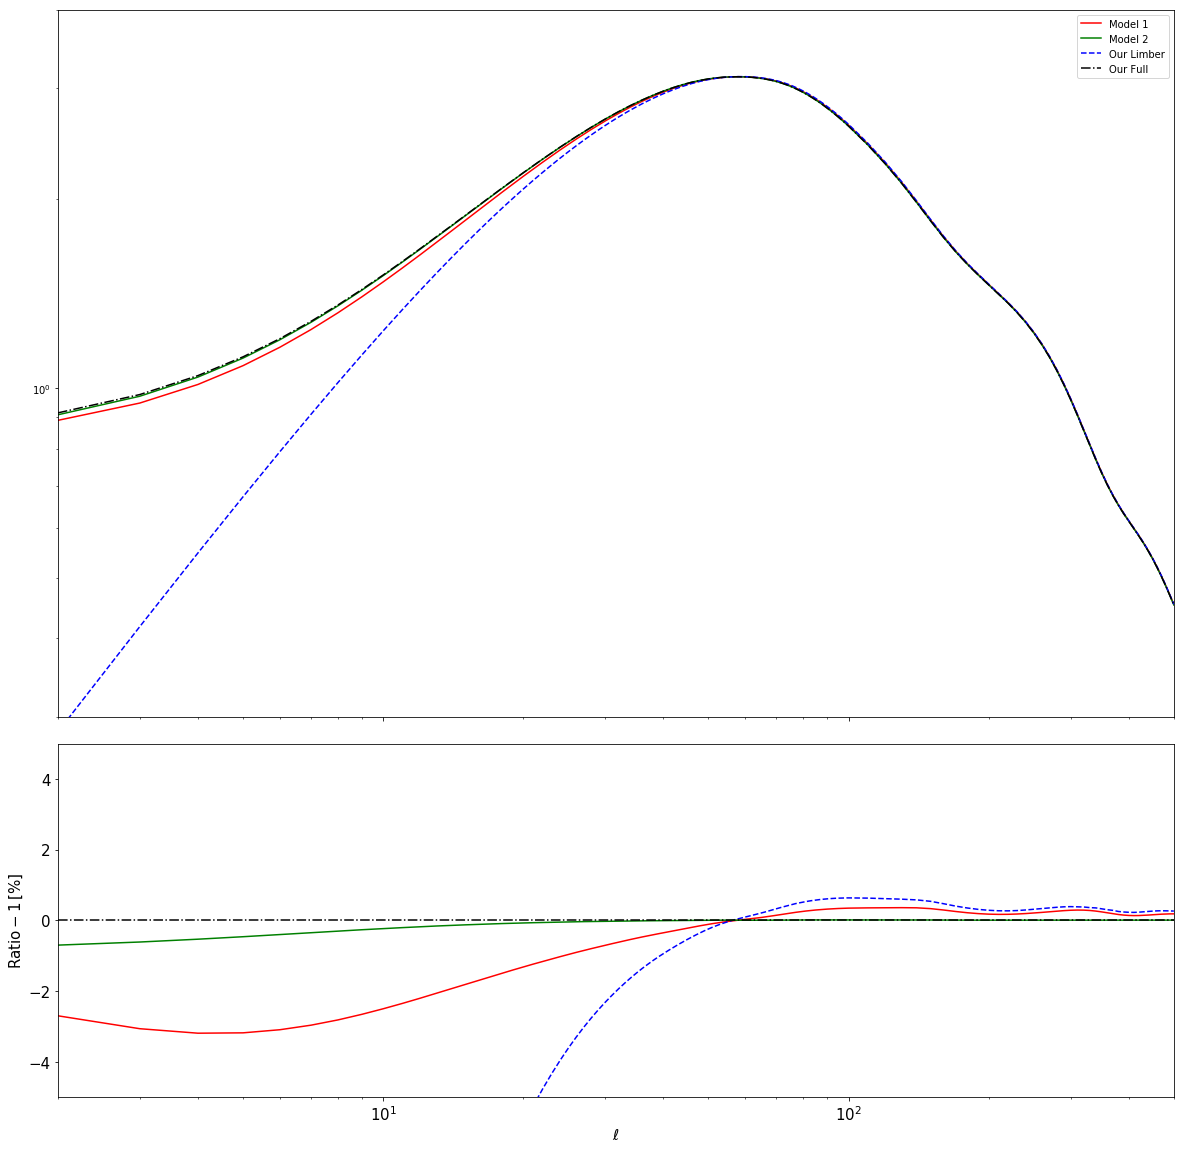

In [961]:
Cl22_full = np.loadtxt('./Full-sky/Cl_22_number.txt')[:,1]
fig, axes = plt.subplots(2,1, figsize=(20,20), sharex=True, gridspec_kw={'height_ratios': [2, 1],'hspace':0.05})
ax0,ax1 = axes[0],axes[1]

ax0.plot(our_l, np.abs(Cl22_chi_dchi_1)*1e7, color='r',label=r'Model 1')
ax0.plot(our_l, np.abs(Cl22_chi_dchi_2)*1e7, color='g' , label=r'Model 2')
#ax0.plot(our_l, np.abs(Cl1125_chi_dchi_3)*1e7, color='c' , label=r'Model 3')
ax0.plot(our_l, np.abs(C22_03_limber)*1e7,'--' , color='b',label=r'Our Limber')
ax0.plot(our_l, np.abs(Cl22_full)*1e7,'-.', color='k', label=r'Our Full' )
ax0.legend()
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_ylim(0.3, 4)
ax0.set_xlim(2, 500)

ax1.plot(our_l, (Cl22_chi_dchi_1/Cl22_full-1)*1e2,color='r')
ax1.plot(our_l, (C22_03_limber/Cl22_full-1)*1e2,'--',color='b')
ax1.plot(our_l, (Cl22_chi_dchi_2/Cl22_full-1)*1e2,color='g')
#ax1.plot(our_l, (Cl22_chi_dchi_3/Cl1125_full-1)*1e2,color='c')
ax1.plot(our_l, [0. for i in range(len(our_l))],'-.', color = 'k')

ax1.set_xscale('log')
ax1.set_ylim(-5, 5)
ax1.set_xlim(2, 500)
ax1.tick_params(axis='both', labelsize=15)
ax1.set_xlabel(r'$\ell$',fontsize=15)
ax1.set_ylabel(r'$\rm Ratio-1\,[\%]$',fontsize=15)

Text(0, 0.5, '$\\rm Ratio-1\\,[\\%]$')

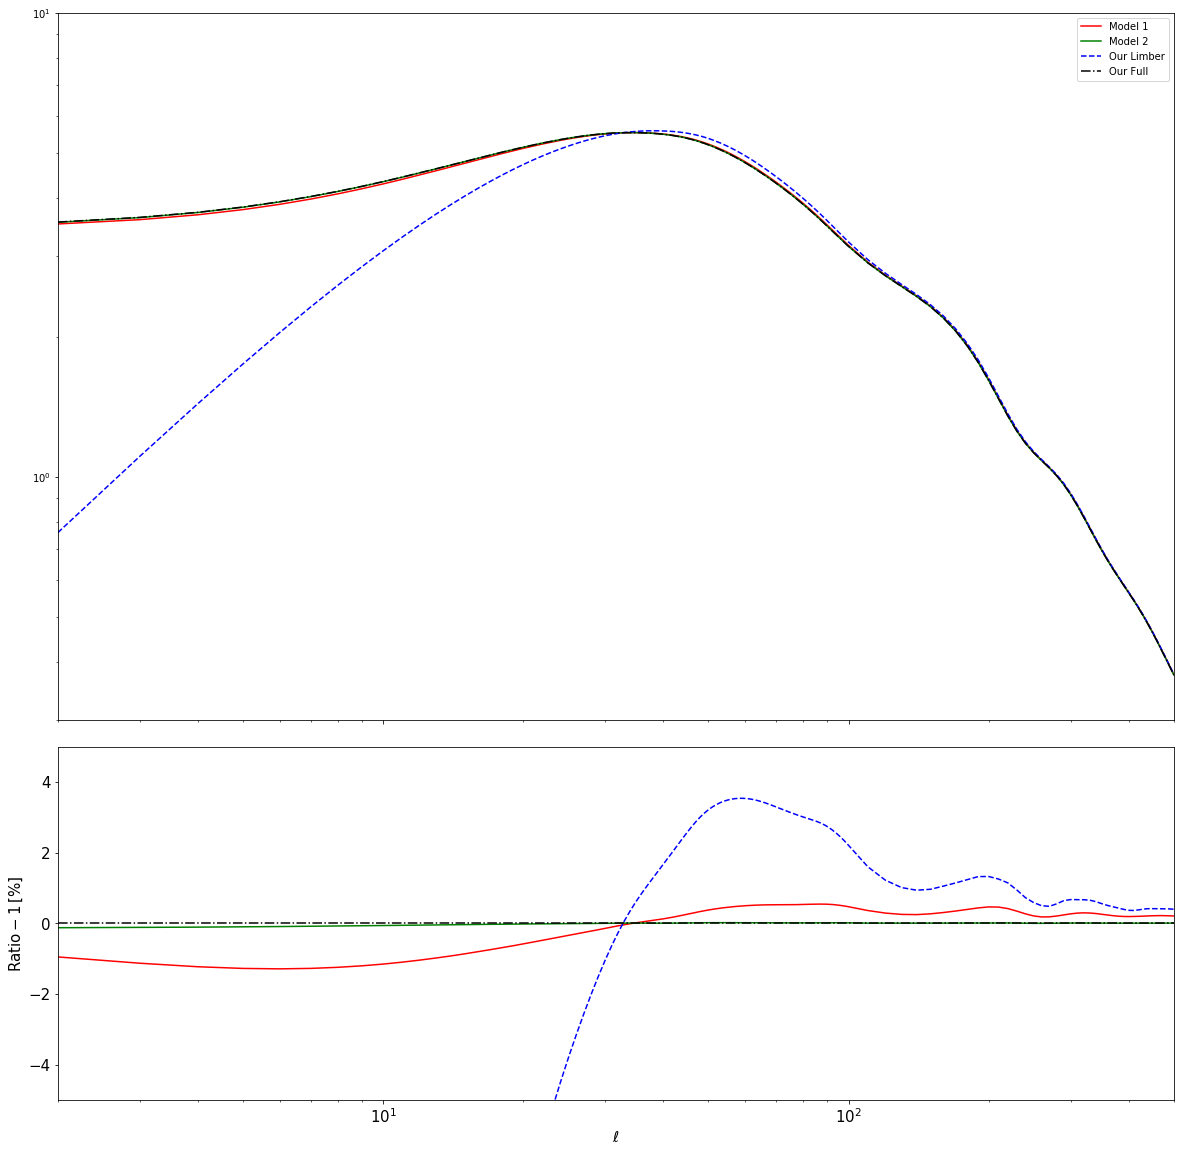

In [963]:
Cl11_full = np.loadtxt('./Full-sky/Cl_11_number.txt')[:,1]
fig, axes = plt.subplots(2,1, figsize=(20,20), sharex=True, gridspec_kw={'height_ratios': [2, 1],'hspace':0.05})
ax0,ax1 = axes[0],axes[1]

ax0.plot(our_l, np.abs(Cl11_chi_dchi_1)*1e6, color='r',label=r'Model 1')
ax0.plot(our_l, np.abs(Cl11_chi_dchi_2)*1e6, color='g' , label=r'Model 2')
#ax0.plot(our_l, np.abs(Cl1125_chi_dchi_3)*1e7, color='c' , label=r'Model 3')
ax0.plot(our_l, np.abs(C11_005_limber)*1e6,'--' , color='b',label=r'Our Limber')
ax0.plot(our_l, np.abs(Cl11_full)*1e6,'-.', color='k', label=r'Our Full' )
ax0.legend()
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_ylim(0.3, 10)
ax0.set_xlim(2, 500)

ax1.plot(our_l, (Cl11_chi_dchi_1/Cl11_full-1)*1e2,color='r')
ax1.plot(our_l, (C11_005_limber/Cl11_full-1)*1e2,'--',color='b')
ax1.plot(our_l, (Cl11_chi_dchi_2/Cl11_full-1)*1e2,color='g')
#ax1.plot(our_l, (Cl22_chi_dchi_3/Cl1125_full-1)*1e2,color='c')
ax1.plot(our_l, [0. for i in range(len(our_l))],'-.', color = 'k')

ax1.set_xscale('log')
ax1.set_ylim(-5, 5)
ax1.set_xlim(2, 500)
ax1.tick_params(axis='both', labelsize=15)
ax1.set_xlabel(r'$\ell$',fontsize=15)
ax1.set_ylabel(r'$\rm Ratio-1\,[\%]$',fontsize=15)

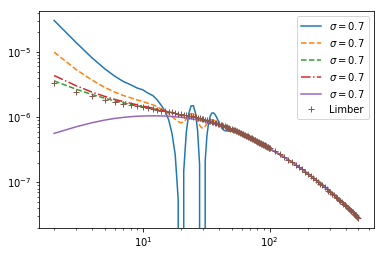

In [384]:
#plt.loglog(our_l, Cl11_11, label=r'$\sigma=0.1$')
#plt.loglog(our_l, Cl11_55, label=r'$\sigma=0.5$')
#plt.loglog(our_l, Cl11_55_fine,'-.' ,label=r'$\sigma=0.5$')
plt.loglog(our_l, Cl11_77, label=r'$\sigma=0.7$')
plt.loglog(our_l, Cl11_77_fine,'--' ,label=r'$\sigma=0.7$')
plt.loglog(our_l[our_l<20], Cl11_77_part,'--' ,label=r'$\sigma=0.7$')
plt.loglog(our_l, Cl11_77_finer,'-.' ,label=r'$\sigma=0.7$')
plt.loglog(our_l, Cl11_77_chi_dchi,label=r'$\sigma=0.7$')
#plt.loglog(our_l, Cl11_77_chi_dchi_new,label=r'$\sigma=0.7$')
plt.loglog(our_l, C_77_limber,'+',label=r'Limber')
#plt.loglog(our_l, Cl11_1010,label=r'$\sigma=1.0$')
#plt.title(r'$z=1,\ \sigma=0.1$')
plt.legend()

Text(0, 0.5, '$C_g$')

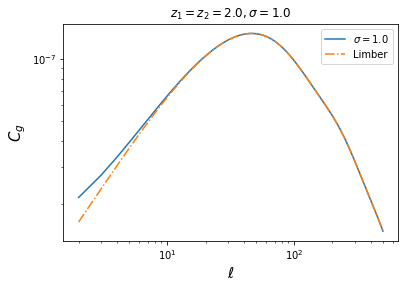

In [567]:
plt.loglog(our_l, Cl22_1010_chi_dchi, label=r'$\sigma=1.0$')
plt.loglog(our_l, C_1010_limber,'-.',label=r'Limber')

plt.legend()
plt.xlabel(r'$\ell$',fontsize=15)
plt.title(r'$z_1=z_2=2.0, \sigma=1.0$')
plt.ylabel(r'$C_g$',fontsize=15)

Text(0, 0.5, '$C_g$')

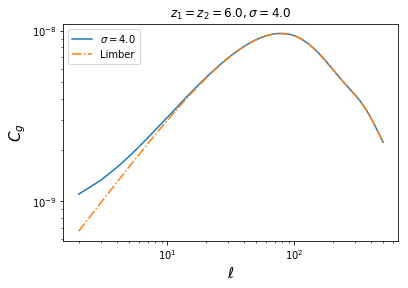

In [568]:
plt.loglog(our_l, Cl66_4040_chi_dchi, label=r'$\sigma=4.0$')
plt.loglog(our_l, C66_4040_limber,'-.',label=r'Limber')

plt.legend()
plt.xlabel(r'$\ell$',fontsize=15)
plt.title(r'$z_1=z_2=6.0, \sigma=4.0$')
plt.ylabel(r'$C_g$',fontsize=15)

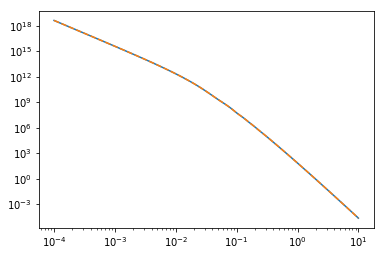

In [400]:
from matplotlib import pyplot as plt
def delta_PFT(kh):
    '''
    term1 = c_n_array[int(Nmax/2)]*kh**(nu_n_array[int(Nmax/2)]-4)
    term2_array = [c_n_array[int(Nmax/2)+i]*kh**(nu_n_array[int(Nmax/2)+i]-4) for i in range(1, int(Nmax/2)+1)]
    '''
    #term1 = c_n_array[int(Nmax/2)]*kh**(nu_n_array[int(Nmax/2)])
    term2_array = [c_n_array[i]*kh**(nu_n_array[i]-4) for i in range(Nmax+1)]
    return (np.sum(term2_array)).real

kh_array = 10**np.array([-4 + i*5/100 for i in range(101)])
pkk4 = Power_spectrum(kh_array, 0, 1, 1)
pkk4_re = np.array([delta_PFT(ki) for ki in kh_array])

plt.loglog(kh_array, pkk4)
plt.loglog(kh_array, pkk4_re, '--')

### For the galaxy clustering case, now we can try to use Assassi's calibration, using hyper-geometric function:

In [707]:
def power_calc_full(l, n, chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, c_n_array):
    
    Cl_array = curly_C_cluster_mesh(l, chi_chi, dchi_dchi, c_n_array)

    Simp_array = D1_D1*D2_D2*Cl_array*Wg1_Wg1*Wg2_Wg2*2/np.pi
    #Simp_array = D1_D1*D2_D2*Cl_array*Wg1_Wg1*Wg2_Wg2*(dchi_dchi/chi_chi)**n/chi_chi**2
    intover_dchi = np.array([simps(Simp_array[:,i], dchi_dchi[:,i]) for i in range(len(chi_chi[0,:]))])
    results = simps(intover_dchi, chi_chi[0, :])
    return results

def full_calc_full(l_array, n, z1, z2, sigma1, sigma2, Nchi, Ndchi, c_n_array = c_n_array):
    '''
    Params:
    l_array: The array of multiples we have chosen to consider
    The meaning of rest parameters could be found above
    c_n_array: the decomposed coefficients array

    Return:
    An list of angular power spectrum given l_array
    '''
    start1 = time.time()
    chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2 = mesh_grid_generator3(z1, z2, sigma1, sigma2, Nchi, Ndchi)
    end1 = time.time()-start1
    print('Time for preparing mesh-grids is:', end1, 's')
    start2 = time.time()
    power_array = [power_calc_full(li, n, chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, c_n_array).real for li in l_array]
    end2 = (time.time()-start2)/len(l_array)
    print('Time for calculating each l is:', end2, 's')

    return np.array(power_array)

# Here we turn to study CMB lensing power spectrum:

### Here we write the sampling using $\chi_1$ and $\chi_2$:

In [483]:
def Wlensing(chi, chi_star):
        '''
        Here we consider the general used lensing window function
        '''

        return -2*(chi_star-chi)/(chi_star*chi)
    
def mesh_grid_generator_CMBlensing(Nchi1, Nchi2):
        '''
        Params:
        z1, z2: the redshifts of our objects
        sigma1, sigma2: the dispersion of our window function
        Nchi, Ndchi: fidicually chosen length of the sampling array

        Return:
        mesh-grids of chi_chi, dchi_dchi, 
        and, growth factors D1_D1, D2_D2.
        '''
        chi_min = 0.1
        chi_max = defcos.chi(1101)
        #chi1_array = 10**np.array([np.log10(chi_min) + i*np.log10(chi_max/chi_min)/Nchi1 for i in range(Nchi1)])
        #chi2_array = 10**np.array([np.log10(chi_min+0.1) + i*np.log10(chi_max/(chi_min+0.1))/Nchi2 for i in range(Nchi2)])
        chi1_array = np.array([chi_min + i*(chi_max-chi_min)/Nchi1 for i in range(Nchi1+1)])
        chi2_array = np.array([chi_min+0.1 + i*(chi_max-chi_min)/Nchi2 for i in range(Nchi2+1)])
        chi1_chi1, chi2_chi2 = np.meshgrid(chi1_array, chi2_array)
        #dchi_array = np.array(list(-10**np.array([-1+(np.log10(chi_max-chi_min)+1)/Ndchi*i for i in range(Ndchi+1)])[::-1])\
                #+list(10**np.array([-1+(np.log10(chi_max-chi_min)+1)/Ndchi*i for i in range(Ndchi+1)])))
        #Create the sample grid
        D1_array = np.array([defcos.Dg_norm(chi1) for chi1 in chi1_array])
        D2_array = np.array([defcos.Dg_norm(chi2) for chi2 in chi2_array])
        D1_D1, D2_D2 = np.meshgrid(D1_array, D2_array)

        Wg1_Wg1 = Wlensing(chi1_chi1, defcos.chi(1100))
        Wg2_Wg2 = Wlensing(chi2_chi2, defcos.chi(1100))
        F1_array = defcos.Psi_normalizer(chi1_array)
        F2_array = defcos.Psi_normalizer(chi2_array)
        F1_F1, F2_F2 = np.meshgrid(F1_array, F2_array)

        return chi1_chi1, chi2_chi2, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, F1_F1, F2_F2

def power_calc_sampling_CMBlensing(l, n, chi1_chi1, chi2_chi2, D1_D1, D2_D2, W1_W1, W2_W2, F1_F1, F2_F2, c_n_array):
    '''
    Params:
    l: The multiple
    n: The order of our approximation, usually order 0 will be good enough
    chi_chi, dchi_dchi: The 2D mesh-grid of the chi (dchi) parameter. 
                        The n_row is the same as length of dchi array, 
                        while the n_columns is the same as length of chi array.
    D1_D1, D2_D2: The mesh-grid of growth factor. The same shape as chi_chi.
    Wg1_Wg1, Wg2_Wg2: The mesh-grid of several window functions.
    F1_Wg1, F2_F2: The mesh-grid of potential factors.

    Return:
    The angular power spetrum at mutiple l.
    '''
    dchi_dchi = chi2_chi2-chi1_chi1
    dchi_dchi[dchi_dchi==0] = 1e-16
    xx = dchi_dchi *l/chi2_chi2
    xx[np.abs(xx)<0.0001] = 0.0001
    xx[np.abs(xx)>49999999]= 49999999

    Cl_array_array = np.array([ (c_n_array[i]*(func_real_list[i](np.abs(xx))+1j*func_imag_list[i](np.abs(xx))))*\
        np.abs(dchi_dchi)**(-nu_n_array[i]-1+4) for i in range(int(Nmax)+1)])
    '''
    Cl_array_array = np.array([ (c_n_array[i+int(Nmax/2)+1]*(func_real_list[i](np.abs(xx))+1j*func_imag_list[i](np.abs(xx))))*\
        np.abs(dchi_dchi)**(-nu_n_array[i+int(Nmax/2)+1]-1) for i in range(int(Nmax/2))])
    '''
    '''
    Cl_array_array = np.array([ (c_n_array[i]*(func_real_list[i](xx)+1j*func_imag_list[i](xx)))*\
        dchi_dchi**(-nu_n_array[i]-1+4) for i in range(int(Nmax)+1)])
    '''
    #Cl_array_array[np.isnan(Cl_array_array)]=0.
    Cl_array = np.sum(Cl_array_array, axis=0)

    Simp_array = 2*F1_F1*F2_F2*D1_D1*D2_D2*Cl_array*W1_W1*W2_W2*4/(chi1_chi1+chi2_chi2)**2
    results = simps(simps(Simp_array, chi1_chi1[0, :]), chi2_chi2[:, 0])
    return results

def full_calc_sampling_CMBlensing(l_array, n, Nchi, Ndchi, c_n_array = c_n_array):
    '''
    Params:
    l_array: The array of multiples we have chosen to consider
    The meaning of rest parameters could be found above
    c_n_array: the decomposed coefficients array

    Return:
    An list of angular power spectrum given l_array
    '''
    start1 = time.time()
    chi_chi, dchi_dchi, D1_D1, D2_D2, W1_W1, W2_W2, F1_F1, F2_F2 = mesh_grid_generator_CMBlensing(Nchi, Ndchi)
    end1 = time.time()-start1
    print('Time for preparing mesh-grids is:', end1, 's')
    start2 = time.time()
    power_array = [power_calc_sampling_CMBlensing(li, n, chi_chi, dchi_dchi, D1_D1, D2_D2, W1_W1, W2_W2, F1_F1, F2_F2, c_n_array).real for li in l_array]
    end2 = (time.time()-start2)/len(l_array)
    print('Time for calculating each l is:', end2, 's')

    return power_array

### Here we write down the sampling using $\bar{\chi}$ and $\delta\chi$:

In [937]:
def Wlensing(chi, chi_star):
        '''
        Here we consider the general used lensing window function
        '''

        return -2*(chi_star-chi)/(chi_star*chi)
    
def mesh_grid_generator_CMBlensing1(Nchi, Ndchi):
        '''
        Params:
        z1, z2: the redshifts of our objects
        sigma1, sigma2: the dispersion of our window function
        Nchi, Ndchi: fidicually chosen length of the sampling array

        Return:
        mesh-grids of chi_chi, dchi_dchi, 
        and, growth factors D1_D1, D2_D2.
        '''
        chi_min = 100.0
        chi_max = defcos.chi(1100)
        chi_array = np.array([chi_min + i*(chi_max-chi_min)/Nchi for i in range(Nchi)])
        dchi_basline = np.arange(2*Ndchi+2)
        D1_D1 = np.zeros((2*Ndchi+2, Nchi))
        D2_D2 = np.zeros((2*Ndchi+2, Nchi))
        F1_F1 = np.zeros((2*Ndchi+2, Nchi))
        F2_F2 = np.zeros((2*Ndchi+2, Nchi))

        chi_chi, dchi_dchi_raw = np.meshgrid(chi_array, dchi_basline)
        dchi_dchi_list = []
        for i in range(Nchi):
            dchi_max = min(2*chi_array[i], 2*(defcos.chi(2200)-chi_array[i])) #We can change the maximum comoving distance, but note there are actually upper limit in colossus code
            dchi_array = list(-10**np.array([-2+(np.log10(dchi_max-100)+2)/Ndchi*j for j in range(Ndchi+1)])[::-1])\
                +list(10**np.array([-2+(np.log10(dchi_max-100)+2)/Ndchi*j for j in range(Ndchi+1)]))
            dchi_dchi_list.append(dchi_array)
        dchi_dchi = np.transpose(np.array(dchi_dchi_list))
        print(np.shape(chi_chi), np.shape(dchi_dchi))
        grid1 = chi_chi-0.5*dchi_dchi
        grid2 = chi_chi+0.5*dchi_dchi
        
        for i in range(len(chi_array)):
            for j in range(len(dchi_basline)):
                grid1_ji = grid1[j,i]
                grid2_ji = grid2[j,i]
                D1_D1[j, i] = defcos.Dg_norm(grid1_ji)
                D2_D2[j, i] = defcos.Dg_norm(grid2_ji)
                F1_F1[j, i] = defcos.Psi_normalizer(grid1_ji)
                F2_F2[j, i] = defcos.Psi_normalizer(grid2_ji)

        Wg1_Wg1 = Wlensing(grid1, defcos.chi(1100))
        Wg2_Wg2 = Wlensing(grid2, defcos.chi(1100))

        return chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, F1_F1, F2_F2

def power_calc_sampling_CMBlensing1(l, chi_chi, dchi_dchi, D1_D1, D2_D2, W1_W1, W2_W2, F1_F1, F2_F2, c_n_array):
    '''
    Params:
    l: The multiple
    n: The order of our approximation, usually order 0 will be good enough
    chi_chi, dchi_dchi: The 2D mesh-grid of the chi (dchi) parameter. 
                        The n_row is the same as length of dchi array, 
                        while the n_columns is the same as length of chi array.
    D1_D1, D2_D2: The mesh-grid of growth factor. The same shape as chi_chi.
    Wg1_Wg1, Wg2_Wg2: The mesh-grid of several window functions.
    F1_Wg1, F2_F2: The mesh-grid of potential factors.

    Return:
    The angular power spetrum at mutiple l.
    '''
    #xx = dchi_dchi *l/(chi_chi)/np.sqrt(1-(dchi_dchi/2/chi_chi)**2)
    #l_tilde = l/(chi_chi)/np.sqrt(1-(dchi_dchi/2/chi_chi)**2)
    #xx = dchi_dchi *np.sqrt(l*(l+1))/(chi_chi+0.5*dchi_dchi)/(1-(dchi_dchi/2/chi_chi))
    #l_tilde = np.sqrt(l*(l+1))/(chi_chi+0.5*dchi_dchi)/(1-(dchi_dchi/2/chi_chi))
    xx = dchi_dchi *np.sqrt(l*(l+1))/(chi_chi)/np.sqrt(1-(dchi_dchi/2/chi_chi)**2)
    l_tilde = np.sqrt(l*(l+1))/(chi_chi)/np.sqrt(1-(dchi_dchi/2/chi_chi)**2)

    Cl_array_array = np.array([ (c_n_array[i]*(func_real_list1[i](np.abs(xx))+1j*func_imag_list1[i](np.abs(xx))))*\
        np.abs(l_tilde)**(nu_n_array[i]+1-4) for i in range(int(Nmax)+1)])
    
    #Cl_array_array[np.isnan(Cl_array_array)]=0.
    Cl_array = np.sum(Cl_array_array, axis=0)*(1+(dchi_dchi/2/chi_chi)**2)/(1-(dchi_dchi/2/chi_chi)**2)

    Simp_array = F1_F1*F2_F2*D1_D1*D2_D2*Cl_array*W1_W1*W2_W2/(chi_chi)**2
    intover_dchi = np.array([simps(Simp_array[:,i], dchi_dchi[:,i]) for i in range(len(chi_chi[0,:]))])
    results = simps(intover_dchi, chi_chi[0, :])
    return results

def full_calc_sampling_CMBlensing1(l_array, Nchi, Ndchi, c_n_array = c_n_array):
    '''
    Params:
    l_array: The array of multiples we have chosen to consider
    The meaning of rest parameters could be found above
    c_n_array: the decomposed coefficients array

    Return:
    An list of angular power spectrum given l_array
    '''
    start1 = time.time()
    chi_chi, dchi_dchi, D1_D1, D2_D2, W1_W1, W2_W2, F1_F1, F2_F2 = mesh_grid_generator_CMBlensing1(Nchi, Ndchi)
    end1 = time.time()-start1
    print('Time for preparing mesh-grids is:', end1, 's')
    start2 = time.time()
    power_array = [power_calc_sampling_CMBlensing1(li, chi_chi, dchi_dchi, D1_D1, D2_D2, W1_W1, W2_W2, F1_F1, F2_F2, c_n_array).real for li in l_array]
    end2 = (time.time()-start2)/len(l_array)
    print('Time for calculating each l is:', end2, 's')

    return power_array

In [749]:
def power_calc_full_lensing(l, n, chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2,F1_F1, F2_F2, c_n_array):
    
    Cl_array = curly_C_lensing_mesh(l, chi_chi, dchi_dchi, c_n_array)

    Simp_array = F1_F1*F2_F2*D1_D1*D2_D2*Cl_array*Wg1_Wg1*Wg2_Wg2*2/np.pi
    #Simp_array = D1_D1*D2_D2*Cl_array*Wg1_Wg1*Wg2_Wg2*(dchi_dchi/chi_chi)**n/chi_chi**2
    intover_dchi = np.array([simps(Simp_array[:,i], dchi_dchi[:,i]) for i in range(len(chi_chi[0,:]))])
    results = simps(intover_dchi, chi_chi[0, :])
    return results

def full_calc_full_lensing(l_array, n, Nchi, Ndchi, c_n_array = c_n_array):
    '''
    Params:
    l_array: The array of multiples we have chosen to consider
    The meaning of rest parameters could be found above
    c_n_array: the decomposed coefficients array

    Return:
    An list of angular power spectrum given l_array
    '''
    start1 = time.time()
    chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, F1_F1, F2_F2 = mesh_grid_generator_CMBlensing1(Nchi, Ndchi)
    end1 = time.time()-start1
    print('Time for preparing mesh-grids is:', end1, 's')
    start2 = time.time()
    power_array = [power_calc_full_lensing(li, n, chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2,F1_F1, F2_F2, c_n_array).real for li in l_array]
    end2 = (time.time()-start2)/len(l_array)
    print('Time for calculating each l is:', end2, 's')

    return np.array(power_array)

In [752]:
CMBlensing_full = full_calc_full_lensing([100],0,50,50,c_n_array)

(102, 50) (102, 50)
Time for preparing mesh-grids is: 9.564970970153809 s
Time for calculating each l is: 2235.842533826828 s


In [753]:
CMBlensing_full

array([6.07226309e-15])

In [573]:

xx = dchi_dchi *500/(chi_chi+0.5*dchi_dchi)
#xx[xx==0] = 1
#xx[np.abs(xx)<2e-5] = 2.1e-5
#xx[np.abs(xx)>5e4]= 4.9999e4
print(np.max(np.abs(xx)))
print(np.min(np.abs(xx)))
print(np.max(dchi_dchi))
#print(2*np.pi/9000 *50000)

9124.299877343885
0.0005411115033892424
8181.4746303746715


In [874]:
Cl_CMBlensing_1_new = full_calc_sampling_CMBlensing1(our_l, 50, 50, c_n_array)

(102, 50) (102, 50)
Time for preparing mesh-grids is: 11.209560871124268 s
Time for calculating each l is: 0.15320070355916196 s


In [881]:
chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, F1_F1, F2_F2 = mesh_grid_generator_CMBlensing1(50, 50)
np.save('./Mesh_CMBlensing', [chi_chi, dchi_dchi, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, F1_F1, F2_F2])

(102, 50) (102, 50)


In [789]:
Cl_CMBlensing_2_new = full_calc_sampling_CMBlensing1(our_l, 100, 110, c_n_array1)

(222, 100) (222, 100)
Time for preparing mesh-grids is: 41.38443994522095 s
Time for calculating each l is: 0.4845038695301083 s


In [784]:
Cl_CMBlensing_3_new = full_calc_sampling_CMBlensing1(our_l, 100, 110, c_n_array1)

(222, 100) (222, 100)
Time for preparing mesh-grids is: 41.091339111328125 s
Time for calculating each l is: 0.48746203004027444 s


In [637]:
Cl_CMBlensing_4 = full_calc_sampling_CMBlensing1(our_l, 100, 110, c_n_array)

(222, 100) (222, 100)
Time for preparing mesh-grids is: 41.42609095573425 s
Time for calculating each l is: 0.4991352884031886 s


In [639]:
Cl_CMBlensing_5 = full_calc_sampling_CMBlensing1(our_l, 100, 110, c_n_array)

(222, 100) (222, 100)
Time for preparing mesh-grids is: 42.104525089263916 s
Time for calculating each l is: 0.49288991200838156 s


In [938]:
Cl_CMBlensing_6 = full_calc_sampling_CMBlensing1(our_l, 50, 50, c_n_array)

(102, 50) (102, 50)
Time for preparing mesh-grids is: 10.28569507598877 s
Time for calculating each l is: 0.1381487108820634 s


In [932]:
Cl_CMBlensing_7 = full_calc_sampling_CMBlensing1(our_l, 50, 50, c_n_array)

(102, 50) (102, 50)
Time for preparing mesh-grids is: 9.700181007385254 s
Time for calculating each l is: 0.13837524455228298 s


In [548]:
Cl_CMBlensing_new1_array = full_calc_sampling_CMBlensing1(our_l, 100, 100, c_n_array)

(202, 100) (202, 100)
Time for preparing mesh-grids is: 38.160842180252075 s
Time for calculating each l is: 0.4543780354287127 s


In [595]:
Cl_CMBlensing_new1_mod_array = full_calc_sampling_CMBlensing1(our_l, 100, 100, c_n_array)

(202, 100) (202, 100)
Time for preparing mesh-grids is: 37.46553993225098 s
Time for calculating each l is: 0.4524192295486121 s


In [509]:
Cl_CMBlensing_new1_mod1_array = full_calc_sampling_CMBlensing1(our_l, 100, 110, c_n_array)

(222, 100) (222, 100)
Time for preparing mesh-grids is: 41.23415231704712 s
Time for calculating each l is: 0.4747636901388923 s


In [758]:
l_Assassi_lensing = []
Cl_Assassi_lensing = []
Assassi_file_path = '/Users/cheng/Documents/Researches_at_Cambridge/Limber/1705 2/Mathematica/ClCAMB.txt'
with open(Assassi_file_path,'r') as file:
    lines = file.readlines()
    for line in lines:
        l, C = line.split(',')
        l_Assassi_lensing.append(int(l))
        Cl_Assassi_lensing.append(float(C.strip('\n')))

file.close()
l_lensing = np.array(l_Assassi_lensing)[:500]
Cl_Assassi_lensing_array = np.array(Cl_Assassi_lensing)[:500]

l_Assassi_lensing_limber = []
Cl_Assassi_lensing_limber = []
Assassi_file_path = '/Users/cheng/Documents/Researches_at_Cambridge/Limber/1705 2/Mathematica/ClAssassi_Limber.txt'
with open(Assassi_file_path,'r') as file:
    lines = file.readlines()
    for line in lines:
        l, C = line.split(',')
        l_Assassi_lensing_limber.append(int(l))
        Cl_Assassi_lensing_limber.append(float(C.strip('\n')))

file.close()
l_lensing_limber = np.array(l_Assassi_lensing_limber)[:500]
Cl_Assassi_lensing_limber_array = np.array(Cl_Assassi_lensing_limber)[:500]

In [925]:
our_l = np.loadtxt('./Full-sky/Cl_CMBlensing_number.txt')[:,0]
Cl_CMB = np.loadtxt('./Full-sky/Cl_CMBlensing_number.txt')[:,1]

Text(0, 0.5, '$\\rm Ratio-1\\,[\\%]$')

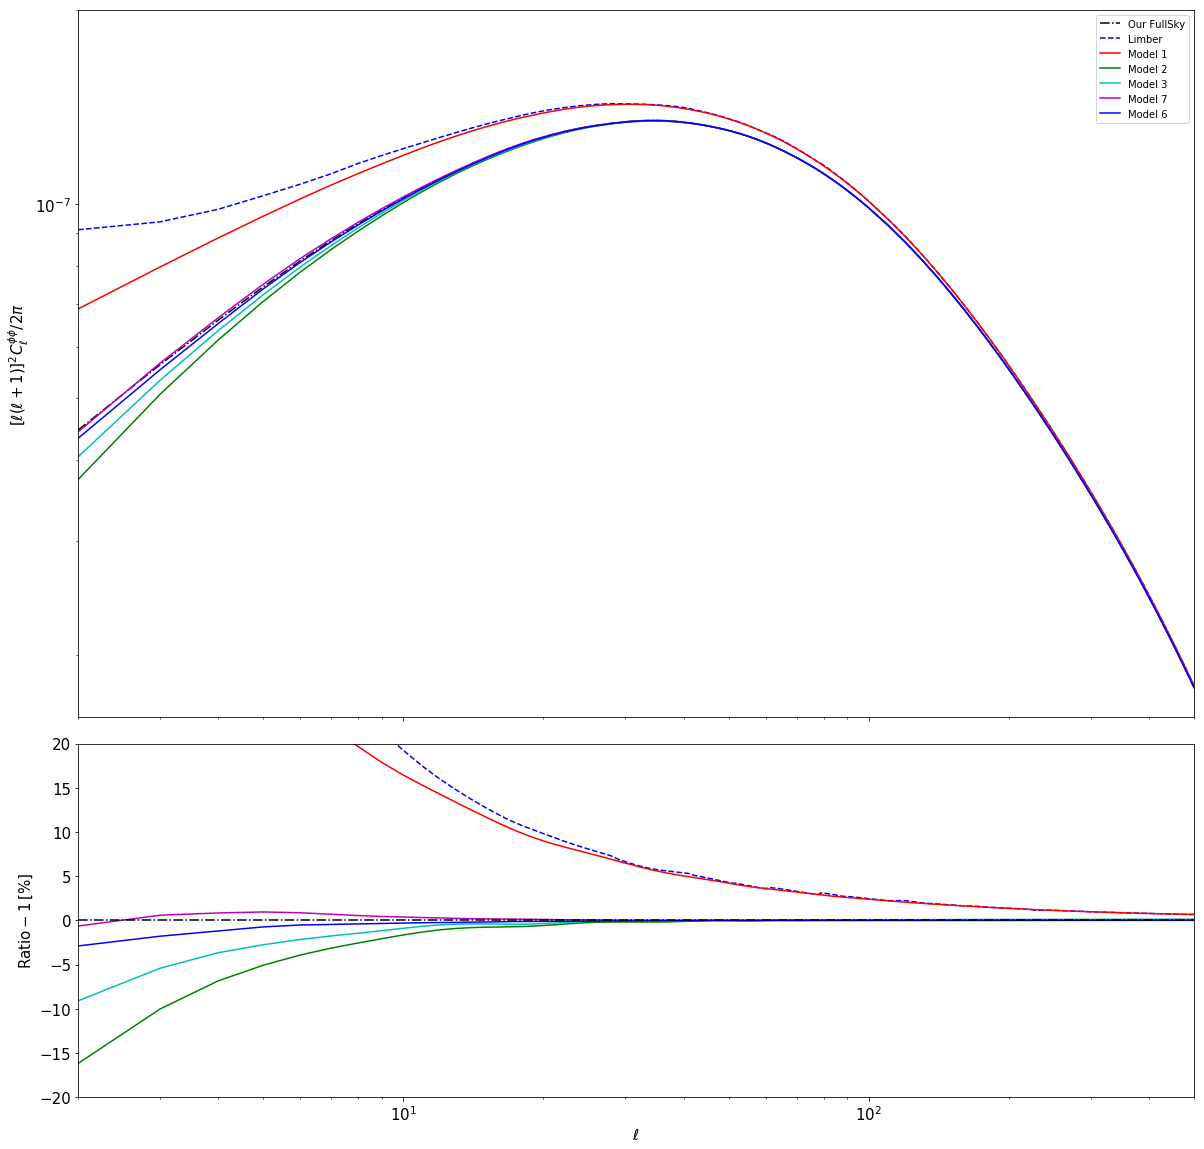

In [939]:
fig, axes = plt.subplots(2,1, figsize=(20,20), sharex=True, gridspec_kw={'height_ratios': [2, 1],'hspace':0.05})
ax0,ax1 = axes[0],axes[1]

#ax0.plot(l_lensing, (l_lensing*(l_lensing+1))**2*Cl_Assassi_lensing_array/(2*np.pi),'-.', color = 'k', label=r'FullSky')
#ax0.plot(l_lensing, (l_lensing*(l_lensing+1))**2*Cl_Assassi_lensing_limber_array/(2*np.pi),'--', color = 'k', label=r'Assassi Limber')
ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMB/(2*np.pi),'-.', color = 'k',label=r'Our FullSky')
ax0.plot(our_l, (our_l*(our_l+1))**2*limber_array1/(2*np.pi), '--', color = 'b', label=r'Limber')
ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing_1/(2*np.pi),color='r' ,label=r'Model 1')
ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing_2/(2*np.pi),color='g' , label=r'Model 2')
ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing_3/(2*np.pi),color='c' , label=r'Model 3')
ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing_7/(2*np.pi),color='m' , label=r'Model 7')
ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing_6/(2*np.pi),color='b' , label=r'Model 6')

ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_ylim(1.6e-8, 2e-7)
ax0.set_xlim(2, 500)
ax0.legend()
#ax0.xlabel(r'$\ell$',fontsize=15)
ax0.set_ylabel(r'$[\ell(\ell+1)]^2C_{\ell}^{\phi\phi}/2\pi$', fontsize=15)
ax0.tick_params(labelsize=15)
plt.setp(ax0.get_xticklabels(), visible=False)

func_full1 = interp1d(our_l, Cl_CMB)
ax1.plot(our_l, (limber_array1/Cl_CMB-1)*1e2,'--',color='b')
#ax1.plot(l_lensing, (Cl_Assassi_lensing_limber_array/Cl_Assassi_lensing_array-1)*1e2,'--',color='k')
#ax1.plot([3], (np.array([2.45718282249314388e-9])/func_full(3)-1)*1e2,'*',markersize=15,color='k')
ax1.plot(our_l, (Cl_CMBlensing_1/Cl_CMB-1)*1e2,color='r')
ax1.plot(our_l, (Cl_CMBlensing_2/Cl_CMB-1)*1e2,color='g')
ax1.plot(our_l, (Cl_CMBlensing_3/Cl_CMB-1)*1e2,color='c')
ax1.plot(our_l, (Cl_CMBlensing_7/Cl_CMB-1)*1e2,color='m')
ax1.plot(our_l, (Cl_CMBlensing_6/Cl_CMB-1)*1e2,color='b')

ax1.plot(our_l, [0. for i in range(len(our_l))],'-.', color='k')
    
ax1.set_xscale('log')
ax1.set_ylim(-20, 20)
ax1.set_xlim(2, 500)
ax1.tick_params(axis='both', labelsize=15)
ax1.set_xlabel(r'$\ell$',fontsize=15)
ax1.set_ylabel(r'$\rm Ratio-1\,[\%]$',fontsize=15)

Text(0, 0.5, '$\\rm Ratio-1\\,[\\%]$')

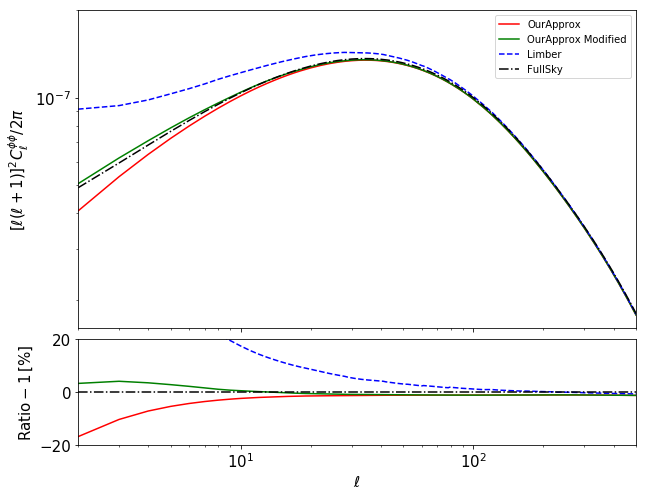

In [534]:
from scipy.interpolate import interp1d

fig, axes = plt.subplots(2,1, figsize=(10,8), sharex=True, gridspec_kw={'height_ratios': [3, 1],'hspace':0.05})
ax0,ax1 = axes[0],axes[1]

ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing_new1_array/(2*np.pi), color = 'r', label=r'OurApprox')
ax0.plot(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing_new1_mod1_array/(2*np.pi), color = 'g', label=r'OurApprox Modified')
ax0.plot(our_l, (our_l*(our_l+1))**2*limber_array/(2*np.pi), '--', color = 'b', label=r'Limber')
#ax0.plot(l_prime, np.abs(np.array(our_Cl))*rescale, color = 'g', label=r'OurApprox Modified')
ax0.plot(l_lensing, (l_lensing*(l_lensing+1))**2*Cl_Assassi_lensing_array/(2*np.pi),'-.', color = 'k', label=r'FullSky')
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_ylim(1.6e-8, 2e-7)
ax0.set_xlim(2, 500)
ax0.legend()
#ax0.xlabel(r'$\ell$',fontsize=15)
ax0.set_ylabel(r'$[\ell(\ell+1)]^2C_{\ell}^{\phi\phi}/2\pi$', fontsize=15)
ax0.tick_params(labelsize=15)
plt.setp(ax0.get_xticklabels(), visible=False)
func_full = interp1d(l_lensing, Cl_Assassi_lensing_array)
ax1.plot(our_l, (Cl_CMBlensing_new1_array/func_full(our_l)-1)*100, color='r')
ax1.plot(our_l, (limber_array/func_full(our_l)-1)*100,'--', color='b')
ax1.plot(our_l, (Cl_CMBlensing_new1_mod1_array/func_full(our_l)-1)*100, color='g')
ax1.plot(our_l, [0. for i in range(len(our_l))],'-.', color='k')
    
ax1.set_xscale('log')
ax1.set_ylim(-20, 20)
ax1.set_xlim(2, 500)
ax1.tick_params(axis='both', labelsize=15)
ax1.set_xlabel(r'$\ell$',fontsize=15)
ax1.set_ylabel(r'$\rm Ratio-1\,[\%]$',fontsize=15)
#plt.savefig('./Cl_data/Plots/Cl_CMBlensing_mod.pdf', dpi=200)

In [329]:
plt.loglog(our_l, limber_array/Cl_Assassi_lensing_array-1,'--',label=r'Limber')
plt.loglog(l_kappa, (Cl_kappa*(l_kappa+1)**2/l_kappa**2/2/np.pi)/((l_lensing*(l_lensing+1))**2*Cl_Assassi_lensing_array/(2*np.pi)),'-.', label=r'Our Kappa')

ValueError: operands could not be broadcast together with shapes (139,) (500,) 

Text(0, 0.5, '$[\\ell(\\ell+1)]^2C_\\ell^{\\phi\\phi}/2\\pi$')

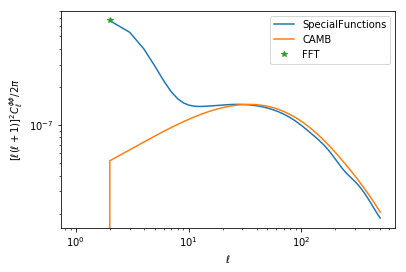

In [181]:
from matplotlib import pyplot as plt
#plt.loglog(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing/(2*np.pi),label=r'SpecialFunctions')

plt.loglog(np.arange(501), Dlpp[:,0], label=r'CAMB')
plt.loglog([2], (2*3)**2*lensing_fft/2/np.pi,'*',label=r'FFT')

plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel('$[\ell(\ell+1)]^2C_\ell^{\phi\phi}/2\pi$')

In [511]:
l_12grid = np.array([2+2*i for i in range(50)]+[100+100*j for j in range(1,5)])
finer_12grid = np.load('./results.npy')

Text(0, 0.5, '$[\\ell(\\ell+1)]^2C_\\ell^{\\phi\\phi}/2\\pi$')

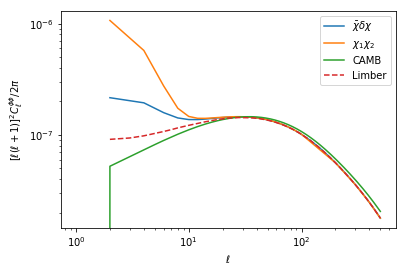

In [513]:
#plt.loglog(our_l[our_l<50], (our_l[our_l<50]*(our_l[our_l<50]+1))**2*Cl_CMBlensing/(2*np.pi),label=r'SpecialFunctions')
plt.loglog(our_l[0:200:2], (our_l[0:200:2]*(our_l[0:200:2]+1))**2*Cl_CMBlensing_array/(2*np.pi),label=r'$\bar{\chi}\delta\chi$')
plt.loglog(l_12grid, (l_12grid*(l_12grid+1))**2*finer_12grid/(2*np.pi),label=r'$\chi_1\chi_2$')
plt.loglog(np.arange(501), Dlpp[:,0], label=r'CAMB')
plt.loglog(our_l, (our_l*(our_l+1))**2*limber_array/(2*np.pi),'--',label=r'Limber')

plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel('$[\ell(\ell+1)]^2C_\ell^{\phi\phi}/2\pi$')

### Here we also try to descend our approximation to Limber's approximation to see whether it will give us the expected value.

In [876]:
from scipy.integrate import quad
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))
import params as pa
'''
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.11, ombh2=0.02207, omch2=0.12029, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2.215e-9, ns=0.96, r=0)
pars.set_matter_power(redshifts=[0., 0.8], kmax=140)
pars.set_for_lmax(2500, lens_potential_accuracy=1)
pars.set_dark_energy(w=-1, wa=0, dark_energy_model='fluid')
#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
s8 = np.array(results.get_sigma8())
kh_raw, z_raw, pk_raw = results.get_matter_power_spectrum(minkh=1e-4, maxkh=206, npoints = 728)
print(s8)
kh = kh_raw
print(z_raw[0])
pk = pk_raw[0,:]

kappa_array = [-10.+0.01*i for i in range(int((-np.log(kh[0])/np.log(10.)+0.01)/0.01)+1)]
lowkh = np.array([10**kappa for kappa in kappa_array])
Plowk = np.array([pk[0]*(10**kappa/kh.min())**0.96 for kappa in kappa_array])
kh_new = np.array(list(lowkh)+list(kh[0:]))
Pk_new = np.array(list(Plowk)+list(pk[0:]))
#Initialize the linear power spectrum P(kh) in our given universe
Plinear = interp1d(kh_new, Pk_new)
'''
def Pk_potent(kh):

    return defcos.Plin(kh)/kh**4
    
def Power_spectrum(kh_par, l, chi, dchi):

    #chi = (chi1+chi2)/2
    #delta_chi = chi2-chi1
    #chi = chi1
    #delta_chi = chi2
    kh = np.sqrt(kh_par**2 + (l/chi/np.sqrt(1-(0.5*dchi/chi)**2))**2)

    return Pk_potent(kh)

def Limber_CMBlensing(l, chi_min, chi_star):

    def integrand(chi):
        W1 = Wlensing(chi, chi_star)
        D1 = defcos.Dg_norm(chi)
        F1 = defcos.Psi_normalizer(chi)

        return Power_spectrum(0, l, chi, 0) * (W1**2) * (D1**2) * (F1**2) /chi**2
    
    return quad(integrand, chi_min, chi_star)[0]
    

Using CAMB 1.0.4 installed at /Users/cheng/anaconda3/lib/python3.7/site-packages/camb-1.0.4-py3.7.egg/camb


In [823]:
np.savetxt('./pk_camb_planck18.txt', np.array([kh,pk]).T)

In [782]:
c_n_array1 = sampling_cosmo.CoeffTransfer(Plinear, 0, 0, Nmax, khmin, khmax)[:, 0]

In [919]:
limber_array1 = np.array([Limber_CMBlensing(li, 0.1, defcos.chi(1100)) for li in our_l])

In [803]:
np.shape(np.arange(501))

(501,)

/Users/cheng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0, '$\\ell$')

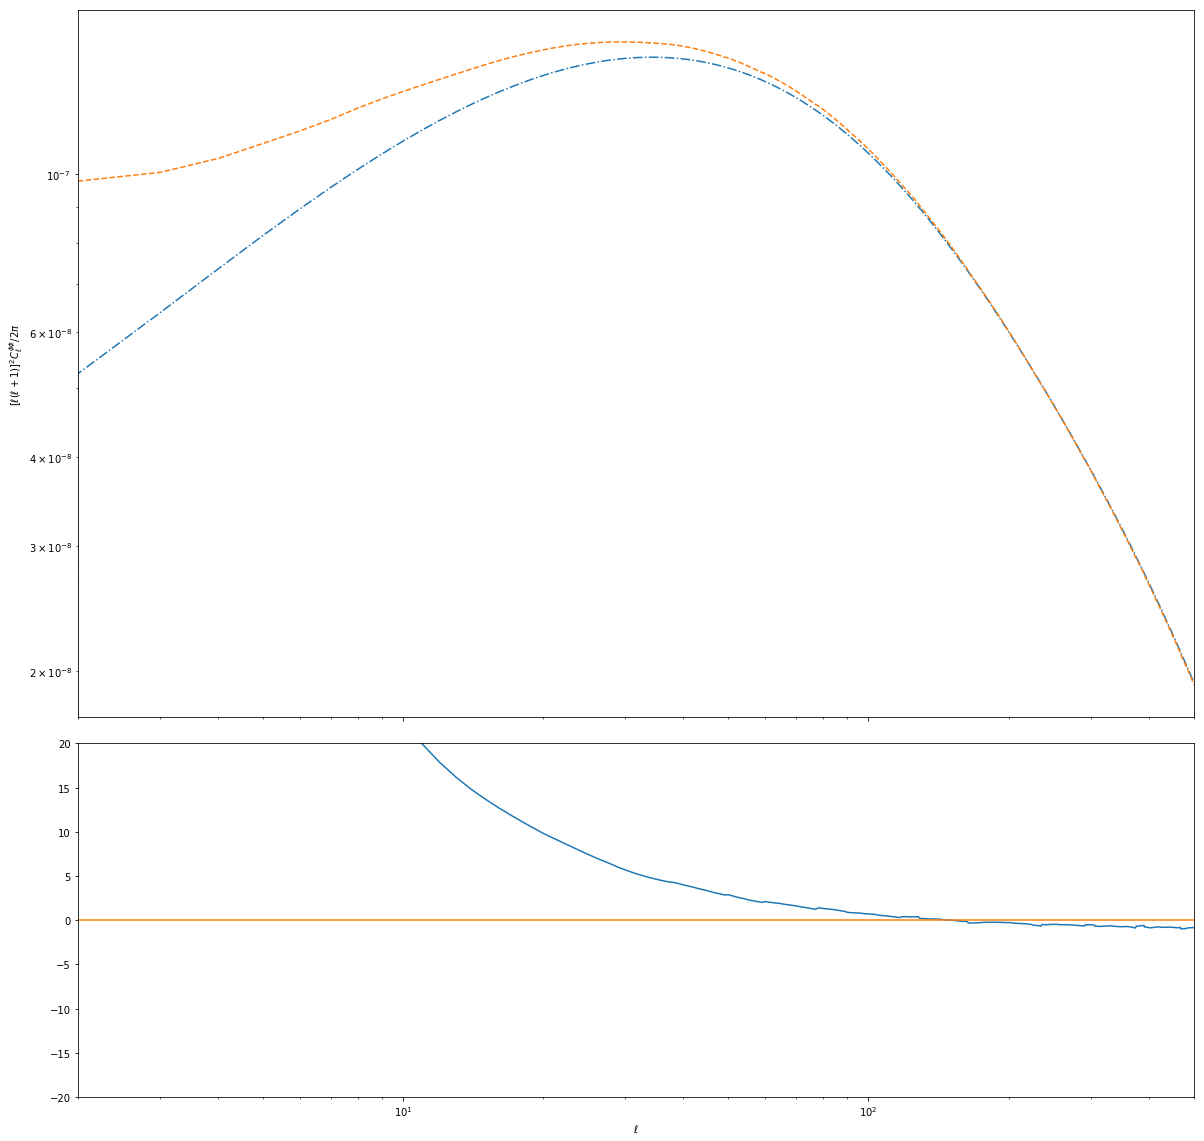

<Figure size 1440x1440 with 0 Axes>

In [809]:
fig, axes = plt.subplots(2,1, figsize=(20,20), sharex=True, gridspec_kw={'height_ratios': [2, 1],'hspace':0.05})
ax0,ax1 = axes[0],axes[1]
plt.figure(figsize=(20,20))
Dlpp = results.get_lens_potential_cls(lmax = 500)
ax0.loglog(np.arange(501), Dlpp[:,0],'-.')
ax0.loglog(l_lensing, (l_lensing*(l_lensing+1))**2*limber_array1/(2*np.pi),'--')
ax0.set_xlim(2,500)
#plt.loglog(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing_1_new/(2*np.pi))
#plt.loglog(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing_2_new/(2*np.pi))
#plt.loglog(our_l, (our_l*(our_l+1))**2*Cl_CMBlensing_3_new/(2*np.pi))
ax1.plot(l_lensing, ((l_lensing*(l_lensing+1))**2*limber_array1/Dlpp[1:,0]/(2*np.pi)-1)*100)
ax1.plot(l_lensing, [0. for i in range(500)])
ax1.set_xlim(2,500)
ax1.set_ylim(-20,20)
ax0.set_ylabel('$[\ell(\ell+1)]^2C_\ell^{\phi\phi}/2\pi$')
ax1.set_xlabel('$\ell$')

### Here we try to test the result using fft method directly:

In [154]:
'''
def mesh_grid_generator_CMBlensing_fft(Nchi1, Nchi2):
        chi_min = 0.1
        chi_max = defcos.chi(1101)
        #chi1_array = 10**np.array([np.log10(chi_min) + i*np.log10(chi_max/chi_min)/Nchi1 for i in range(Nchi1)])
        #chi2_array = 10**np.array([np.log10(chi_min) + i*np.log10(chi_max/(chi_min))/Nchi2 for i in range(Nchi2)])
        chi1_array = np.array([chi_min + i*(chi_max-chi_min)/Nchi1 for i in range(Nchi1+1)])
        chi2_array = np.array([chi_min + i*(chi_max-chi_min)/Nchi2 for i in range(Nchi2+1)])
        chi1_chi1, chi2_chi2 = np.meshgrid(chi1_array, chi2_array)
        #dchi_array = np.array(list(-10**np.array([-1+(np.log10(chi_max-chi_min)+1)/Ndchi*i for i in range(Ndchi+1)])[::-1])\
                #+list(10**np.array([-1+(np.log10(chi_max-chi_min)+1)/Ndchi*i for i in range(Ndchi+1)])))
        #Create the sample grid
        D1_array = np.array([defcos.Dg_norm(chi1) for chi1 in chi1_array])
        D2_array = np.array([defcos.Dg_norm(chi2) for chi2 in chi2_array])
        D1_D1, D2_D2 = np.meshgrid(D1_array, D2_array)

        Wg1_Wg1 = Wlensing(chi1_chi1, defcos.chi(1100))
        Wg2_Wg2 = Wlensing(chi2_chi2, defcos.chi(1100))
        F1_array = defcos.Psi_normalizer(chi1_array)
        F2_array = defcos.Psi_normalizer(chi2_array)
        F1_F1, F2_F2 = np.meshgrid(F1_array, F2_array)

        return chi1_chi1, chi2_chi2, D1_D1, D2_D2, Wg1_Wg1, Wg2_Wg2, F1_F1, F2_F2
'''

def power_calc_sampling_CMBlensing_fft(l, chi_chi, dchi_dchi, D1_D1, D2_D2, W1_W1, W2_W2, F1_F1, F2_F2):
    '''
    Params:
    l: The multiple
    n: The order of our approximation, usually order 0 will be good enough
    chi_chi, dchi_dchi: The 2D mesh-grid of the chi (dchi) parameter. 
                        The n_row is the same as length of dchi array, 
                        while the n_columns is the same as length of chi array.
    D1_D1, D2_D2: The mesh-grid of growth factor. The same shape as chi_chi.
    Wg1_Wg1, Wg2_Wg2: The mesh-grid of several window functions.
    F1_F1, F2_F2: The mesh-grid of potential factors.

    Return:
    The angular power spetrum at mutiple l.
    '''
    N1 = np.shape(chi_chi)[0]
    N2 = np.shape(dchi_dchi)[1]
    Cl_array = np.zeros((N1, N2))
    for j in range(N2):
        for i in range(N1):
            Cl_array[i,j] = C_fft_kappa(l, chi_chi[i,j], dchi_dchi[i,j])

    np.save('./C_ell/C_l_%d_re_finer'%l, Cl_array)

    Simp_array = F1_F1*F2_F2*D1_D1*D2_D2*Cl_array*W1_W1*W2_W2*chi_chi**2*(1-(dchi_dchi/chi_chi/2)**2)**2
    intover_dchi = np.array([simps(Simp_array[:,i], dchi_dchi[:,i]) for i in range(len(chi_chi[0,:]))])
    results = simps(intover_dchi, chi_chi[0, :])
    return results

def full_calc_sampling_CMBlensing_fft(l_array, Nchi, Ndchi):
    '''
    Params:
    l_array: The array of multiples we have chosen to consider
    The meaning of rest parameters could be found above
    c_n_array: the decomposed coefficients array

    Return:
    An list of angular power spectrum given l_array
    '''
    start1 = time.time()
    chi_chi, dchi_dchi, D1_D1, D2_D2, W1_W1, W2_W2, F1_F1, F2_F2 = mesh_grid_generator_CMBlensing1(Nchi, Ndchi)
    end1 = time.time()-start1
    print('Time for preparing mesh-grids is:', end1, 's')
    start2 = time.time()
    power_array = [power_calc_sampling_CMBlensing_fft(li, chi_chi, dchi_dchi, D1_D1, D2_D2, W1_W1, W2_W2, F1_F1, F2_F2).real for li in l_array]
    end2 = (time.time()-start2)/len(l_array)
    print('Time for calculating each l is:', end2, 's')

    return power_array

In [179]:
Cl_10_kappa_chi_finer = full_calc_sampling_CMBlensing_fft([10], 50, 50)

(102, 200) (102, 200)
Time for preparing mesh-grids is: 37.54720997810364 s
Time for calculating each l is: 921.2897369861603 s


In [164]:
print(Cl_2_kappa[0]*(2+1)**2/2**2/2/np.pi)
print(Cl_4_kappa[0]*(4+1)**2/4**2/2/np.pi)
print(Cl__kappa[0]*(6+1)**2/6**2/2/np.pi)
print(Cl__kappa[1]*(10+1)**2/10**2/2/np.pi)

6.58245275172396e-08
8.787607685443227e-08
1.0220852825103206e-07
1.1968062937407447e-07


In [169]:
l_kappa = np.array([2,4,6,10,20,30,40,60,80,100])
Cl_kappa = np.array([Cl_2_kappa[0], Cl_4_kappa[0], Cl__kappa[0], Cl__kappa[1], Cl_20_80_kappa[0], Cl_20_80_kappa[1], Cl_20_80_kappa[2], Cl_20_80_kappa[3], Cl_20_80_kappa[4], results])

In [123]:
Nchi = 50
Ndchi = 50
chi_chi, dchi_dchi, D1_D1, D2_D2, W1_W1, W2_W2, F1_F1, F2_F2 = mesh_grid_generator_CMBlensing1(Nchi, Ndchi)

(102, 50) (102, 50)


In [135]:
N1 = np.shape(chi_chi)[0]
N2 = np.shape(dchi_dchi)[1]
Cl_array = np.zeros((N1, N2))
for j in range(N2):
    for i in range(N1):
        Cl_array[i,j] = C_fft_kappa(l, chi_chi[i,j], dchi_dchi[i,j])

In [139]:
np.save('./C_ell/C_l_100_re', Cl_array)

In [152]:
Simp_array = F1_F1*F2_F2*D1_D1*D2_D2*Cl_array*W1_W1*W2_W2*chi_chi**2*(1-(dchi_dchi/chi_chi/2)**2)**2
intover_dchi = np.array([simps(Simp_array[:,i], dchi_dchi[:,i]) for i in range(len(chi_chi[0,:]))])
results = simps(intover_dchi, chi_chi[0, :])

In [153]:
results*(l+1)**2/l**2/np.pi/2

1.0086940559427818e-07

In [967]:
10**(-0.16)

0.6918309709189365